## RSNA 2024 Lumbar Spine Degenerative Classification

## 1. Setup

In [1]:
from glob import glob
from tqdm import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

competition_dataset_directory = Path('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification')

In [3]:
train_images = glob(str(competition_dataset_directory / 'train_images' / '*' / '*' / '*.dcm'))

df_train = pd.read_csv(competition_dataset_directory / 'train.csv')
df_train_series_descriptions = pd.read_csv(competition_dataset_directory / 'train_series_descriptions.csv')
df_train_label_coordinates = pd.read_csv(competition_dataset_directory / 'train_label_coordinates.csv')

print(f'Training Images Count {len(train_images)}')
print(f'Training Set Shape: {df_train.shape}')
print(f'Train Series Descriptions Shape: {df_train_series_descriptions.shape}')
print(f'Train Label Coordinates Shape: {df_train_label_coordinates.shape}')

Training Images Count 147218
Training Set Shape: (1975, 26)
Train Series Descriptions Shape: (6294, 3)
Train Label Coordinates Shape: (48692, 7)


## 2. Overview

The problem is to classify five degenerative conditions of the lower spine. There are three core conditions: **spinal canal stenosis**, **neural foraminal narrowing**, and **subarticular stenosis**. The last two of them are considered for each side of the spine, so the targets are left neural foraminal narrowing, right neural foraminal narrowing, left subarticular stenosis, right subarticular stenosis, and spinal canal stenosis. For each imaging study in the dataset, there are three severity scores (Normal/Mild, Moderate, or Severe) given for each of these five conditions at the disc levels L1/L2, L2/L3, L3/L4, L4/L5, and L5/S1.

The disc levels refer to the specific regions of the lumbar spine where the intervertebral discs are located.

* **L1/L2**: The disc between the first (L1) and second (L2) lumbar vertebrae
* **L2/L3**: The disc between the second (L2) and third (L3) lumbar vertebrae
* **L3/L4**: The disc between the third (L3) and fourth (L4) lumbar vertebrae
* **L4/L5**: The disc between the fourth (L4) and fifth (L5) lumbar vertebrae
* **L5/S1**: The disc between the fifth lumbar vertebra (L5) and the first sacral vertebra (S1)

These levels indicate where the spine issues are evaluated and classified. The anatomy of the spine can be seen below.

![anatomy](https://i.ibb.co/pWr25Wh/Screenshot-2024-06-28-at-18-36-06.png)

In [4]:
display(df_train)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


## 3. Conditions

As already mentioned, there are three conditions exist in the dataset. Their distributions among levels could be different, so they have to be analyzed together.

In [5]:
def visualize_condition_counts(df, title, path=None):
    
    """
    Visualize condition counts on training set
    
    Parameters
    ----------
    df: pandas.DataFrame
        Counts and percentages of conditions
        
    title: str
        Title of the plot
        
    path: str, pathlib.Path or None
        Path of the output file (if path is None, plot is displayed with selected backend)
    """
    
    fig, ax = plt.subplots(figsize=(24, 16))

    ax.barh(
        y=np.arange(df.shape[0] // 3) - 0.2,
        width=df['count'].values[0::3],
        height=0.2,
        align='center',
        label='Normal/Mild'
    )
    ax.barh(
        y=np.arange(df.shape[0] // 3),
        width=df['count'].values[1::3],
        height=0.2,
        align='center',
        label='Moderate'
    )
    ax.barh(
        y=np.arange(df.shape[0] // 3) + 0.2,
        width=df['count'].values[2::3],
        height=0.2,
        align='center',
        label='Severe'
    )

    ax.set_yticks(np.arange(df.shape[0] // 3))
    ax.set_yticklabels([
        f'{level}\nNormal Count: {normal_count} ({normal_percentage:.2f}%)\nModerate Count: {moderate_count} ({moderate_percentage:.2f}%)\nSevere Count: {severe_count} ({severe_percentage:.2f}%)' for level, normal_count, normal_percentage, moderate_count, moderate_percentage, severe_count, severe_percentage, in zip(
            df['level'].values[0::3],
            df['count'].values[0::3],
            df['percentage'].values[0::3],
            df['count'].values[1::3],
            df['percentage'].values[1::3],
            df['count'].values[2::3],
            df['percentage'].values[2::3],
        )
    ])
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=17.5, pad=10)
    ax.tick_params(axis='y', labelsize=17.5, pad=10)
    ax.set_title(title, size=20, pad=15)
    ax.legend(loc='best', prop={'size': 18})
    plt.gca().invert_yaxis()

    plt.show()

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


### 3.1. Spinal Canal Stenosis

Spinal canal is the passageway that runs through each of the vertebrae and houses the spinal cord. When the space within the spinal canal becomes narrower, it can squeeze the spinal cord and the nerve roots that branch off from it. This narrowing can irritate, compress, or pinch the spinal cord or nerves, leading to back pain and other nerve-related issues such as sciatica. Various conditions and injuries can cause the spinal canal to become narrowed. Spinal stenosis can affect anyone, but it is most common in people over 50.

![spinal_stenosis](https://i.ibb.co/hf82PDJ/17499-spinal-stenosis-02.jpg)

The condition typically affects two areas of the spine:
* Lower back (lumbar spinal stenosis): The lumbar spine has five vertebrae in the lower back, labeled L1 to L5, which are the largest in the spine
* Neck (cervical spinal stenosis): The cervical spine has seven vertebrae in the neck, labeled C1 to C7

Although less common, the middle back (thoracic spine) can also be affected by spinal stenosis.

In [6]:
spinal_canal_stenosis_columns = [column for column in df_train.columns if column.startswith('spinal_canal_stenosis')]
df_train_spinal_canal_stenosis = []

for column in spinal_canal_stenosis_columns:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'spinal_canal_stenosis'})
    df_train_spinal_canal_stenosis.append(df)
    
df_train_spinal_canal_stenosis = pd.concat(df_train_spinal_canal_stenosis, axis=0).reset_index(drop=True)

df_train_spinal_canal_stenosis_counts = df_train_spinal_canal_stenosis.groupby('level').value_counts().reset_index()
df_train_spinal_canal_stenosis_counts['severity'] = df_train_spinal_canal_stenosis_counts['spinal_canal_stenosis'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_spinal_canal_stenosis_counts = df_train_spinal_canal_stenosis_counts.sort_values(by=['level', 'severity'], ascending=True)
df_train_spinal_canal_stenosis_counts['percentage'] = df_train_spinal_canal_stenosis_counts['count'] / df_train_spinal_canal_stenosis_counts.groupby('level')['count'].transform('sum') * 100

Severity of spinal canal stenosis within different levels are visualized below. This condition is more common in lower levels since moderate and severe counts consistenly increase until reaching L5/S1 level. L5/S1 level has the lowest moderate and severe counts while L4/L5 is the only level that has more severe counts than moderate counts.

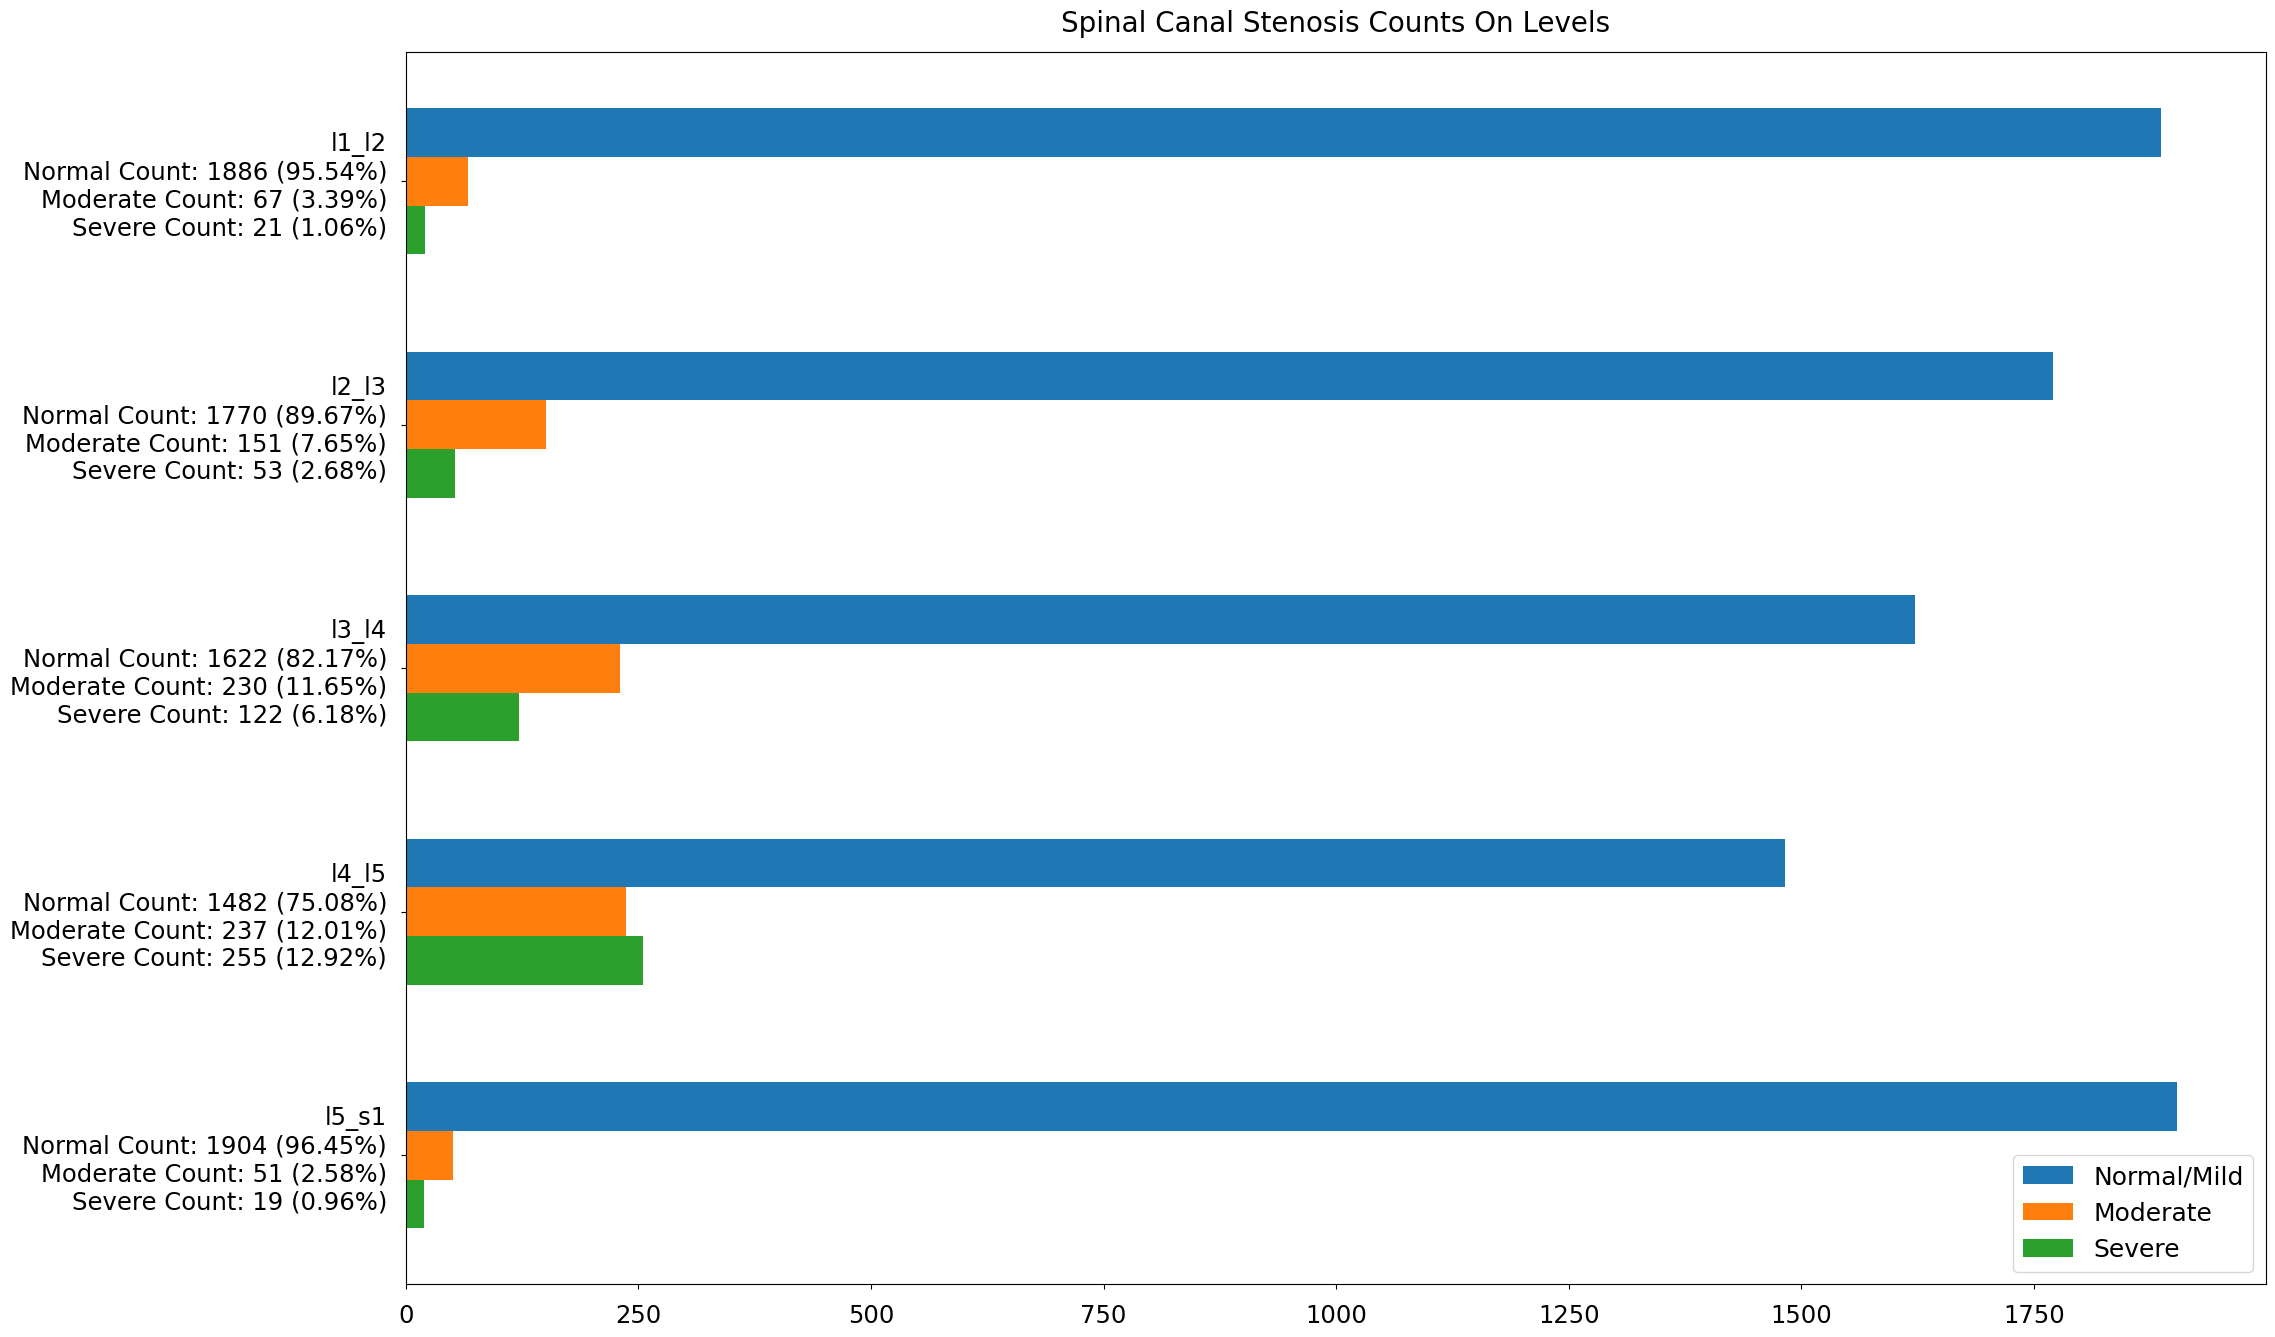

In [7]:
visualize_condition_counts(
    df=df_train_spinal_canal_stenosis_counts,
    title='Spinal Canal Stenosis Counts On Levels'
)

### 3.2. Neural Foraminal Narrowing

Foraminal stenosis is the narrowing that occurs in specific areas around the nerves that exit the spinal cord. It is a type of spinal stenosis affecting the neural foramen, which are openings on both sides of the spine. Foraminal stenosis puts pressure on the affected nerves, which can eventually impact the signals traveling through them, causing nerve pain and potentially permanent nerve damage.

![neural_foraminal_stenosis](https://i.ibb.co/7SQMjTk/24856-foraminal-stenosis.jpg)

A neural foramen is an opening where a spinal nerve exits the spine and branches out to other parts of the body. The size of the opening depends on its location in the spine. The location of the foraminal stenosis determines its type:

* Cervical spine (neck): This is the second most common area for foraminal stenosis
* Thoracic spine (upper and middle back)
* Lumbar spine (lower back): This is the most common area for foraminal stenosis
* Sacral spine (far lower back and pelvis)
* Coccygeal spine (tailbone)

Foraminal stenosis appears to be common, especially in people over age 55, and becomes more likely as people age. Some studies suggest that up to 40% of people have at least moderate foraminal stenosis in their lumbar spine by age 60, increasing to about 75% in those aged 80 and older. However, most people with foraminal stenosis are unaware they have it, even if it is severe. Only 17.5% of people with severe foraminal stenosis experience symptoms.

In [8]:
neural_foraminal_narrowing_columns = [column for column in df_train.columns if 'neural_foraminal_narrowing' in column]
df_train_neural_foraminal_narrowing = []

for column in neural_foraminal_narrowing_columns:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'neural_foraminal_narrowing'})
    df_train_neural_foraminal_narrowing.append(df)
    
df_train_neural_foraminal_narrowing = pd.concat(df_train_neural_foraminal_narrowing, axis=0).reset_index(drop=True)

df_train_neural_foraminal_narrowing_counts = df_train_neural_foraminal_narrowing.groupby('level').value_counts().reset_index()
df_train_neural_foraminal_narrowing_counts['severity'] = df_train_neural_foraminal_narrowing_counts['neural_foraminal_narrowing'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_neural_foraminal_narrowing_counts = df_train_neural_foraminal_narrowing_counts.sort_values(by=['level', 'severity'], ascending=True)
df_train_neural_foraminal_narrowing_counts['percentage'] = df_train_neural_foraminal_narrowing_counts['count'] / df_train_neural_foraminal_narrowing_counts.groupby('level')['count'].transform('sum') * 100

left_neural_foraminal_narrowing_columns = [column for column in df_train.columns if column.startswith('left_neural_foraminal_narrowing')]
df_train_left_neural_foraminal_narrowing = []

for column in left_neural_foraminal_narrowing_columns:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'left_neural_foraminal_narrowing'})
    df_train_left_neural_foraminal_narrowing.append(df)
    
df_train_left_neural_foraminal_narrowing = pd.concat(df_train_left_neural_foraminal_narrowing, axis=0).reset_index(drop=True)

df_train_left_neural_foraminal_narrowing_counts = df_train_left_neural_foraminal_narrowing.groupby('level').value_counts().reset_index()
df_train_left_neural_foraminal_narrowing_counts['severity'] = df_train_left_neural_foraminal_narrowing_counts['left_neural_foraminal_narrowing'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_left_neural_foraminal_narrowing_counts = df_train_left_neural_foraminal_narrowing_counts.sort_values(by=['level', 'severity'], ascending=True)
df_train_left_neural_foraminal_narrowing_counts['percentage'] = df_train_left_neural_foraminal_narrowing_counts['count'] / df_train_left_neural_foraminal_narrowing_counts.groupby('level')['count'].transform('sum') * 100

right_neural_foraminal_narrowing_columns = [column for column in df_train.columns if column.startswith('right_neural_foraminal_narrowing')]
df_train_right_neural_foraminal_narrowing = []

for column in right_neural_foraminal_narrowing_columns:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'right_neural_foraminal_narrowing'})
    df_train_right_neural_foraminal_narrowing.append(df)
    
df_train_right_neural_foraminal_narrowing = pd.concat(df_train_right_neural_foraminal_narrowing, axis=0).reset_index(drop=True)

df_train_right_neural_foraminal_narrowing_counts = df_train_right_neural_foraminal_narrowing.groupby('level').value_counts().reset_index()
df_train_right_neural_foraminal_narrowing_counts['severity'] = df_train_right_neural_foraminal_narrowing_counts['right_neural_foraminal_narrowing'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_right_neural_foraminal_narrowing_counts = df_train_right_neural_foraminal_narrowing_counts.sort_values(by=['level', 'severity'], ascending=True)
df_train_right_neural_foraminal_narrowing_counts['percentage'] = df_train_right_neural_foraminal_narrowing_counts['count'] / df_train_right_neural_foraminal_narrowing_counts.groupby('level')['count'].transform('sum') * 100

Severity of neural foraminal narrowing within different levels are visualized below for left, right and both. This condition is also more common in lower levels. Moderate counts consistenly increase until reaching L5/S1 level and severe counts increase on L5/S1 as well. Severity counts of this condition are consistent between left and right.

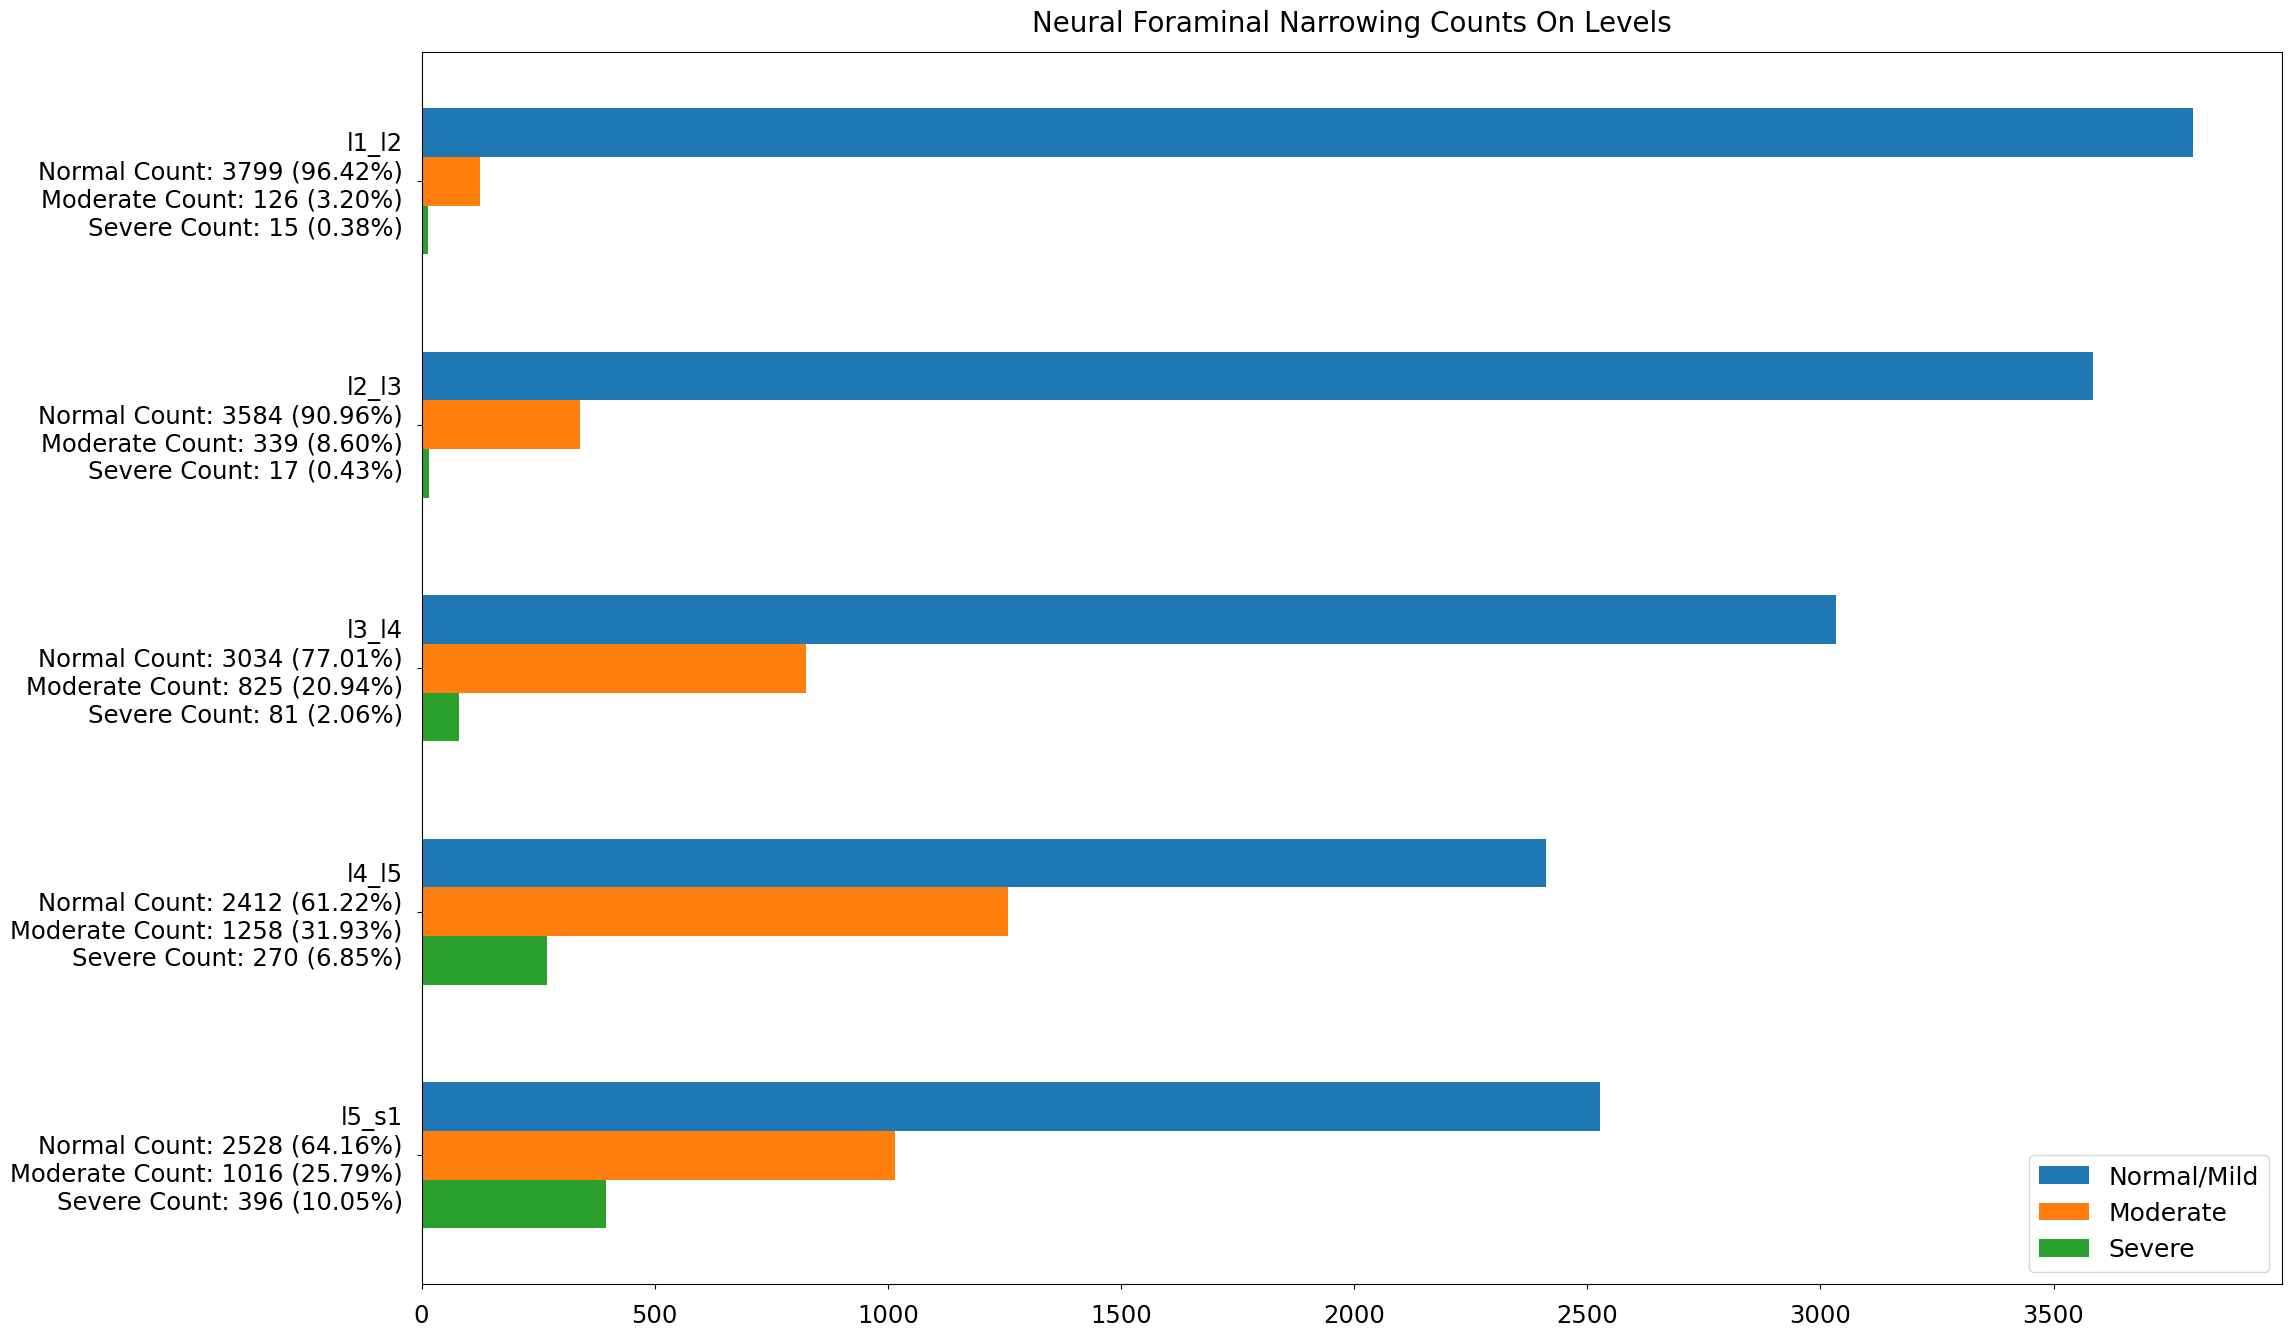

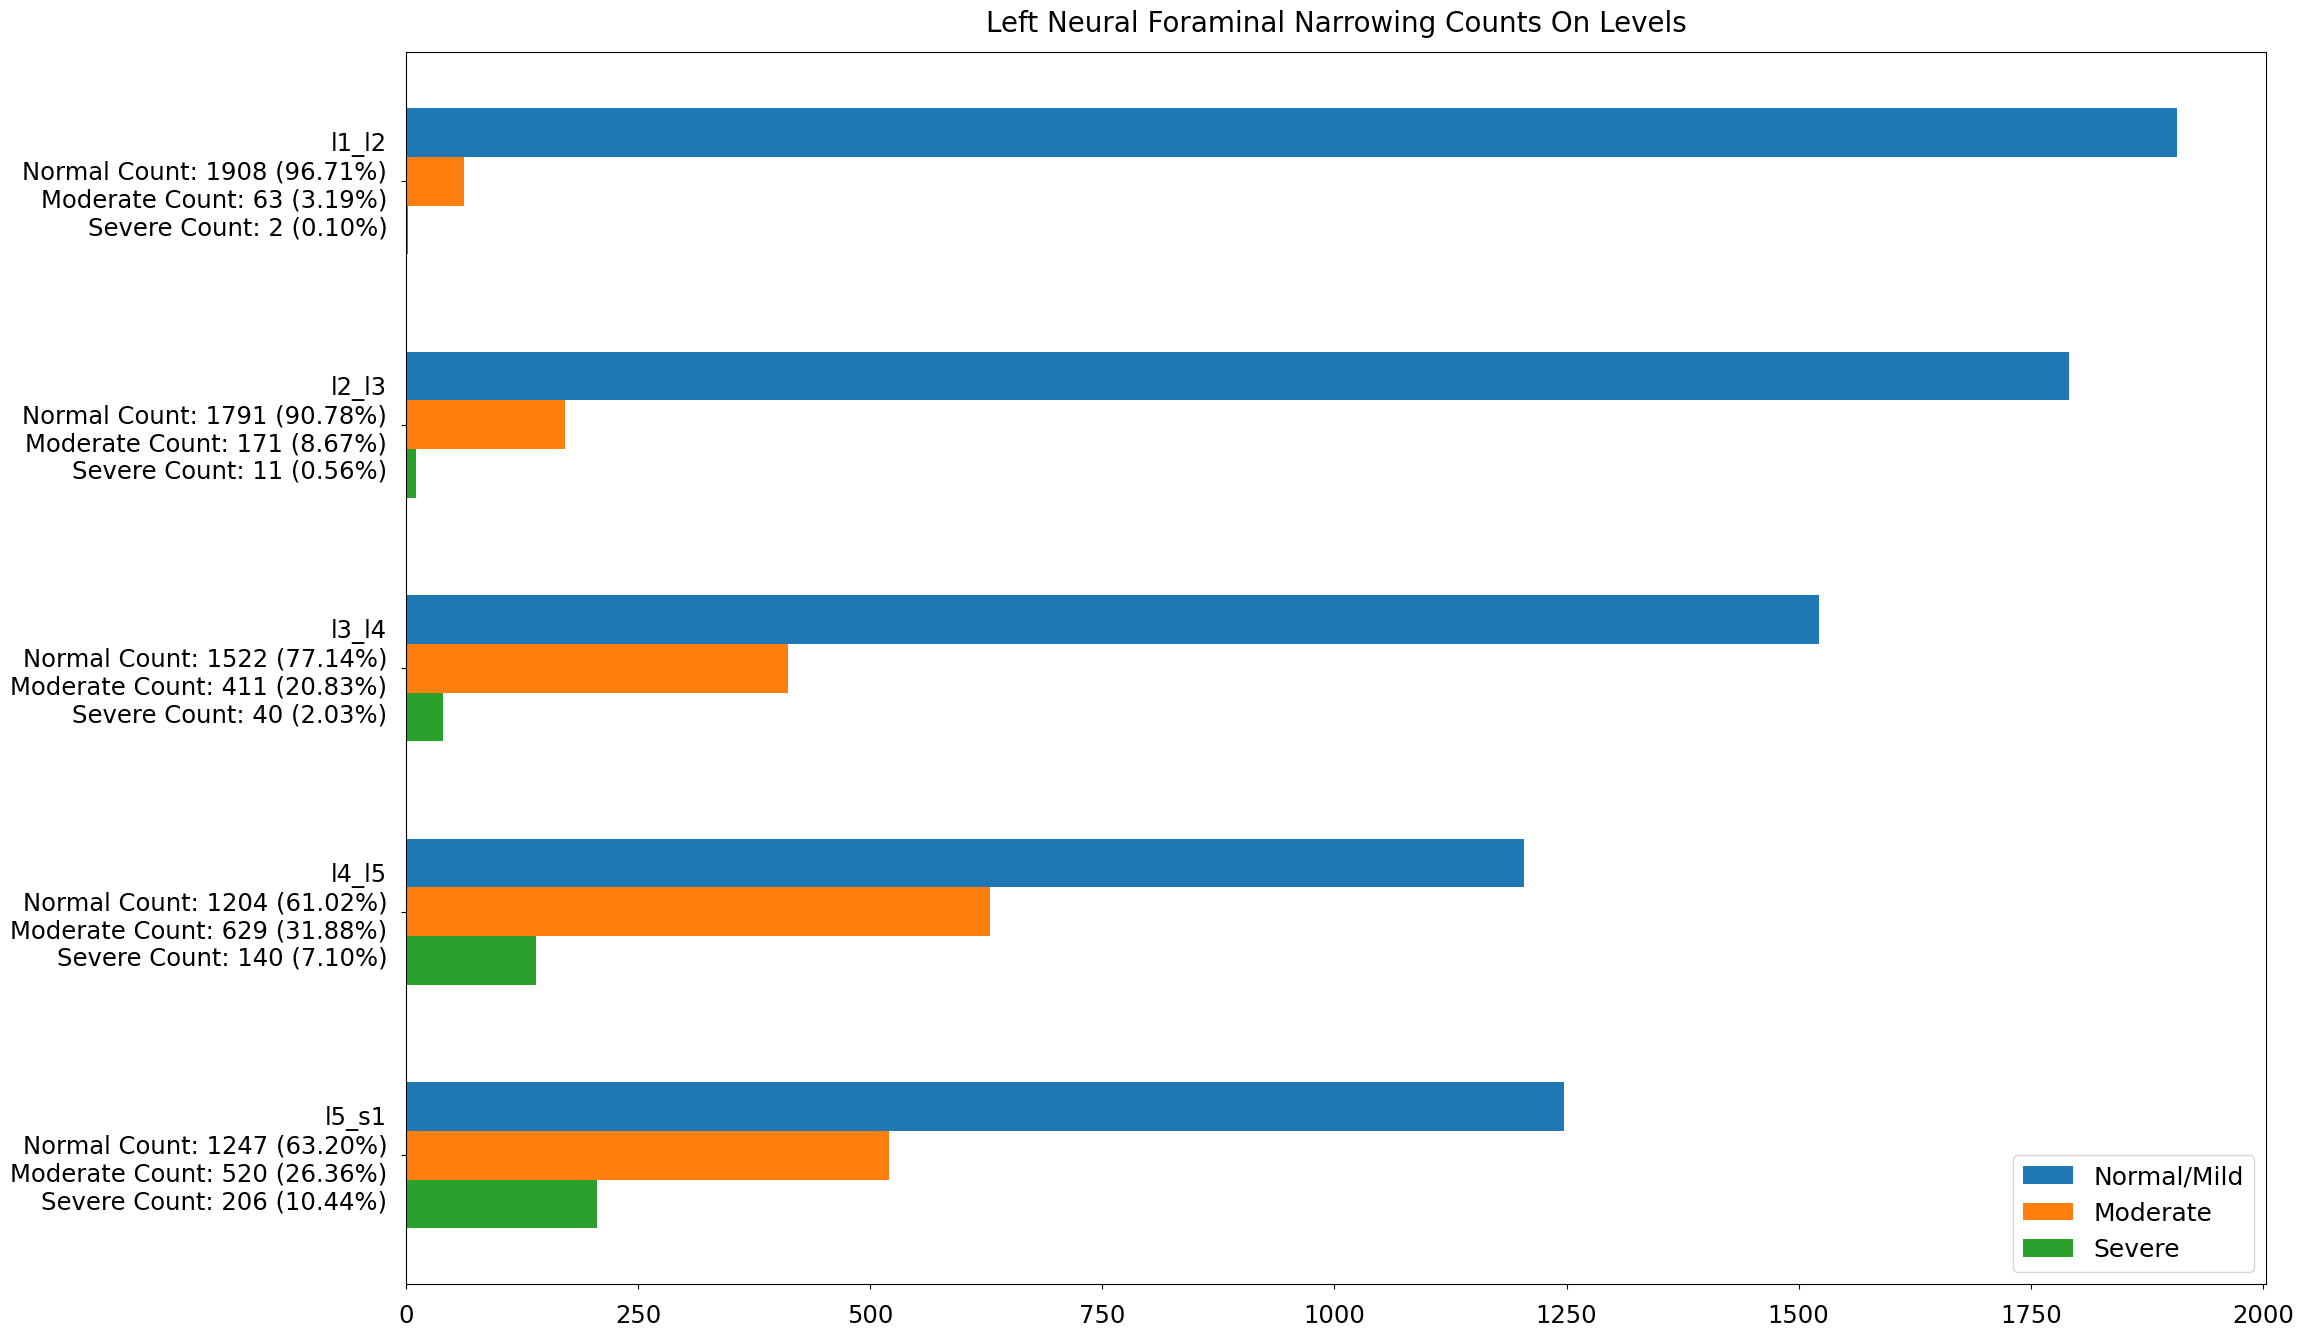

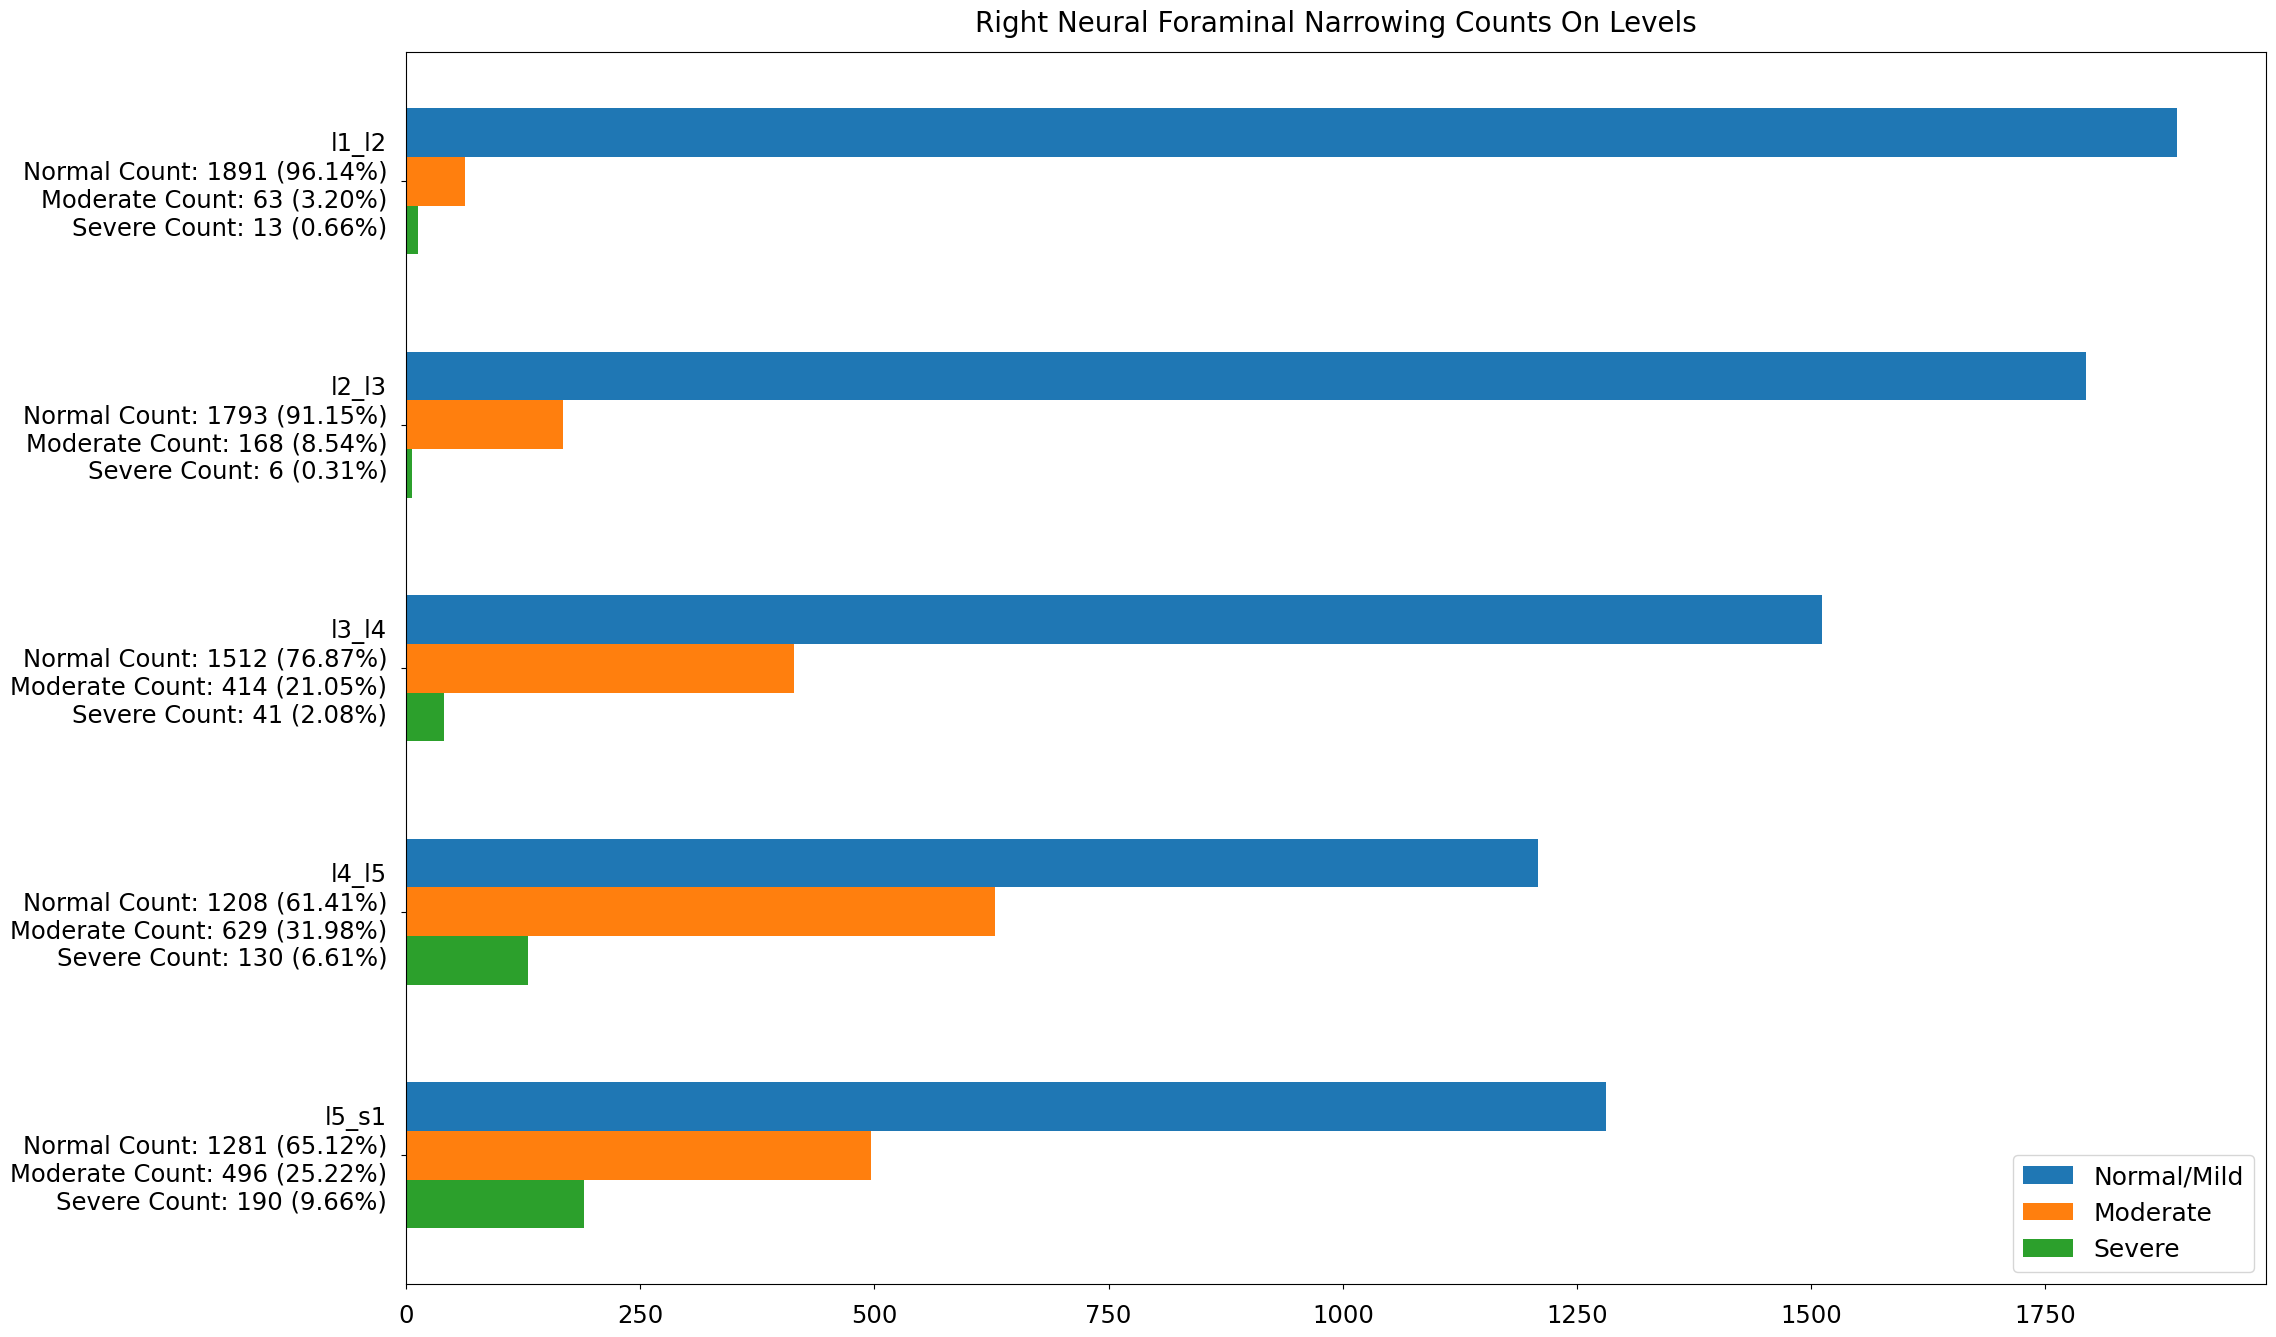

In [9]:
visualize_condition_counts(
    df=df_train_neural_foraminal_narrowing_counts,
    title='Neural Foraminal Narrowing Counts On Levels'
)

visualize_condition_counts(
    df=df_train_left_neural_foraminal_narrowing_counts,
    title='Left Neural Foraminal Narrowing Counts On Levels'
)

visualize_condition_counts(
    df=df_train_right_neural_foraminal_narrowing_counts,
    title='Right Neural Foraminal Narrowing Counts On Levels'
)

In [10]:
neural_foraminal_narrowing_columns = [column for column in df_train.columns if 'neural_foraminal_narrowing' in column]
df_train_left_right_neural_foraminal_narrowing = []

for column in neural_foraminal_narrowing_columns[:5]:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'left_neural_foraminal_narrowing'})
    df_train_left_right_neural_foraminal_narrowing.append(df)

for column in neural_foraminal_narrowing_columns[5:]:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'right_neural_foraminal_narrowing'})
    df_train_left_right_neural_foraminal_narrowing.append(df)
    
df_train_left_right_neural_foraminal_narrowing = pd.concat((
    pd.concat(df_train_left_right_neural_foraminal_narrowing[:5], axis=0).reset_index(drop=True).iloc[:, :1],
    pd.concat(df_train_left_right_neural_foraminal_narrowing[5:], axis=0).reset_index(drop=True)
), axis=1, ignore_index=False)

df_train_left_right_neural_foraminal_narrowing['left_severity'] = df_train_left_right_neural_foraminal_narrowing['left_neural_foraminal_narrowing'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_left_right_neural_foraminal_narrowing['right_severity'] = df_train_left_right_neural_foraminal_narrowing['right_neural_foraminal_narrowing'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_left_right_neural_foraminal_narrowing['level_'] = df_train_left_right_neural_foraminal_narrowing['level'].map({
    'l1_l2': 0,
    'l2_l3': 1,
    'l3_l4': 2,
    'l4_l5': 3,
    'l5_s1': 4
})

Severity of left and right neural foraminal narrowing have correlation coefficient of 0.437 which shows that they are somewhat correlated with each other.

In [11]:
df_neural_foraming_narrowing_correlations = df_train_left_right_neural_foraminal_narrowing[['level_', 'left_severity', 'right_severity']].corr()
display(df_neural_foraming_narrowing_correlations)

,level_,left_severity,right_severity
level_,1.000000,0.334574,0.316862
left_severity,0.334574,1.000000,0.437931
right_severity,0.316862,0.437931,1.000000


### 3.3. Subarticular Stenosis

Subarticular stenosis, also known as lateral recess stenosis, is a condition where the space beneath the facet joints in the spine, known as the lateral recess, becomes narrowed. This space is part of the spinal canal, and its narrowing can compress the spinal nerves as they travel through this area.

![subarticular_stenosis](https://i.ibb.co/F4Nztxm/Lateral-Recess-Stenosis-scaled.jpg)

In [12]:
subarticular_stenosis_columns = [column for column in df_train.columns if 'subarticular_stenosis' in column]
df_train_subarticular_stenosis = []

for column in subarticular_stenosis_columns:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'subarticular_stenosis'})
    df_train_subarticular_stenosis.append(df)
    
df_train_subarticular_stenosis = pd.concat(df_train_subarticular_stenosis, axis=0).reset_index(drop=True)

df_train_subarticular_stenosis_counts = df_train_subarticular_stenosis.groupby('level').value_counts().reset_index()
df_train_subarticular_stenosis_counts['severity'] = df_train_subarticular_stenosis_counts['subarticular_stenosis'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_subarticular_stenosis_counts = df_train_subarticular_stenosis_counts.sort_values(by=['level', 'severity'], ascending=True)
df_train_subarticular_stenosis_counts['percentage'] = df_train_subarticular_stenosis_counts['count'] / df_train_subarticular_stenosis_counts.groupby('level')['count'].transform('sum') * 100

left_subarticular_stenosis_columns = [column for column in df_train.columns if column.startswith('left_subarticular_stenosis')]
df_train_left_subarticular_stenosis = []

for column in left_subarticular_stenosis_columns:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'left_subarticular_stenosis'})
    df_train_left_subarticular_stenosis.append(df)
    
df_train_left_subarticular_stenosis = pd.concat(df_train_left_subarticular_stenosis, axis=0).reset_index(drop=True)

df_train_left_subarticular_stenosis_counts = df_train_left_subarticular_stenosis.groupby('level').value_counts().reset_index()
df_train_left_subarticular_stenosis_counts['severity'] = df_train_left_subarticular_stenosis_counts['left_subarticular_stenosis'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_left_subarticular_stenosis_counts = df_train_left_subarticular_stenosis_counts.sort_values(by=['level', 'severity'], ascending=True)
df_train_left_subarticular_stenosis_counts['percentage'] = df_train_left_subarticular_stenosis_counts['count'] / df_train_left_subarticular_stenosis_counts.groupby('level')['count'].transform('sum') * 100

right_subarticular_stenosis_columns = [column for column in df_train.columns if column.startswith('right_subarticular_stenosis')]
df_train_right_subarticular_stenosis = []

for column in right_subarticular_stenosis_columns:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'right_subarticular_stenosis'})
    df_train_right_subarticular_stenosis.append(df)
    
df_train_right_subarticular_stenosis = pd.concat(df_train_right_subarticular_stenosis, axis=0).reset_index(drop=True)

df_train_right_subarticular_stenosis_counts = df_train_right_subarticular_stenosis.groupby('level').value_counts().reset_index()
df_train_right_subarticular_stenosis_counts['severity'] = df_train_right_subarticular_stenosis_counts['right_subarticular_stenosis'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_right_subarticular_stenosis_counts = df_train_right_subarticular_stenosis_counts.sort_values(by=['level', 'severity'], ascending=True)
df_train_right_subarticular_stenosis_counts['percentage'] = df_train_right_subarticular_stenosis_counts['count'] / df_train_right_subarticular_stenosis_counts.groupby('level')['count'].transform('sum') * 100

Severity of subarticular stenosis within different levels are visualized below for left, right and both. This condition is also more common in lower levels. However, moderate and severe counts are way higher compared to other two conditions. Severity counts of this condition are consistent between left and right.

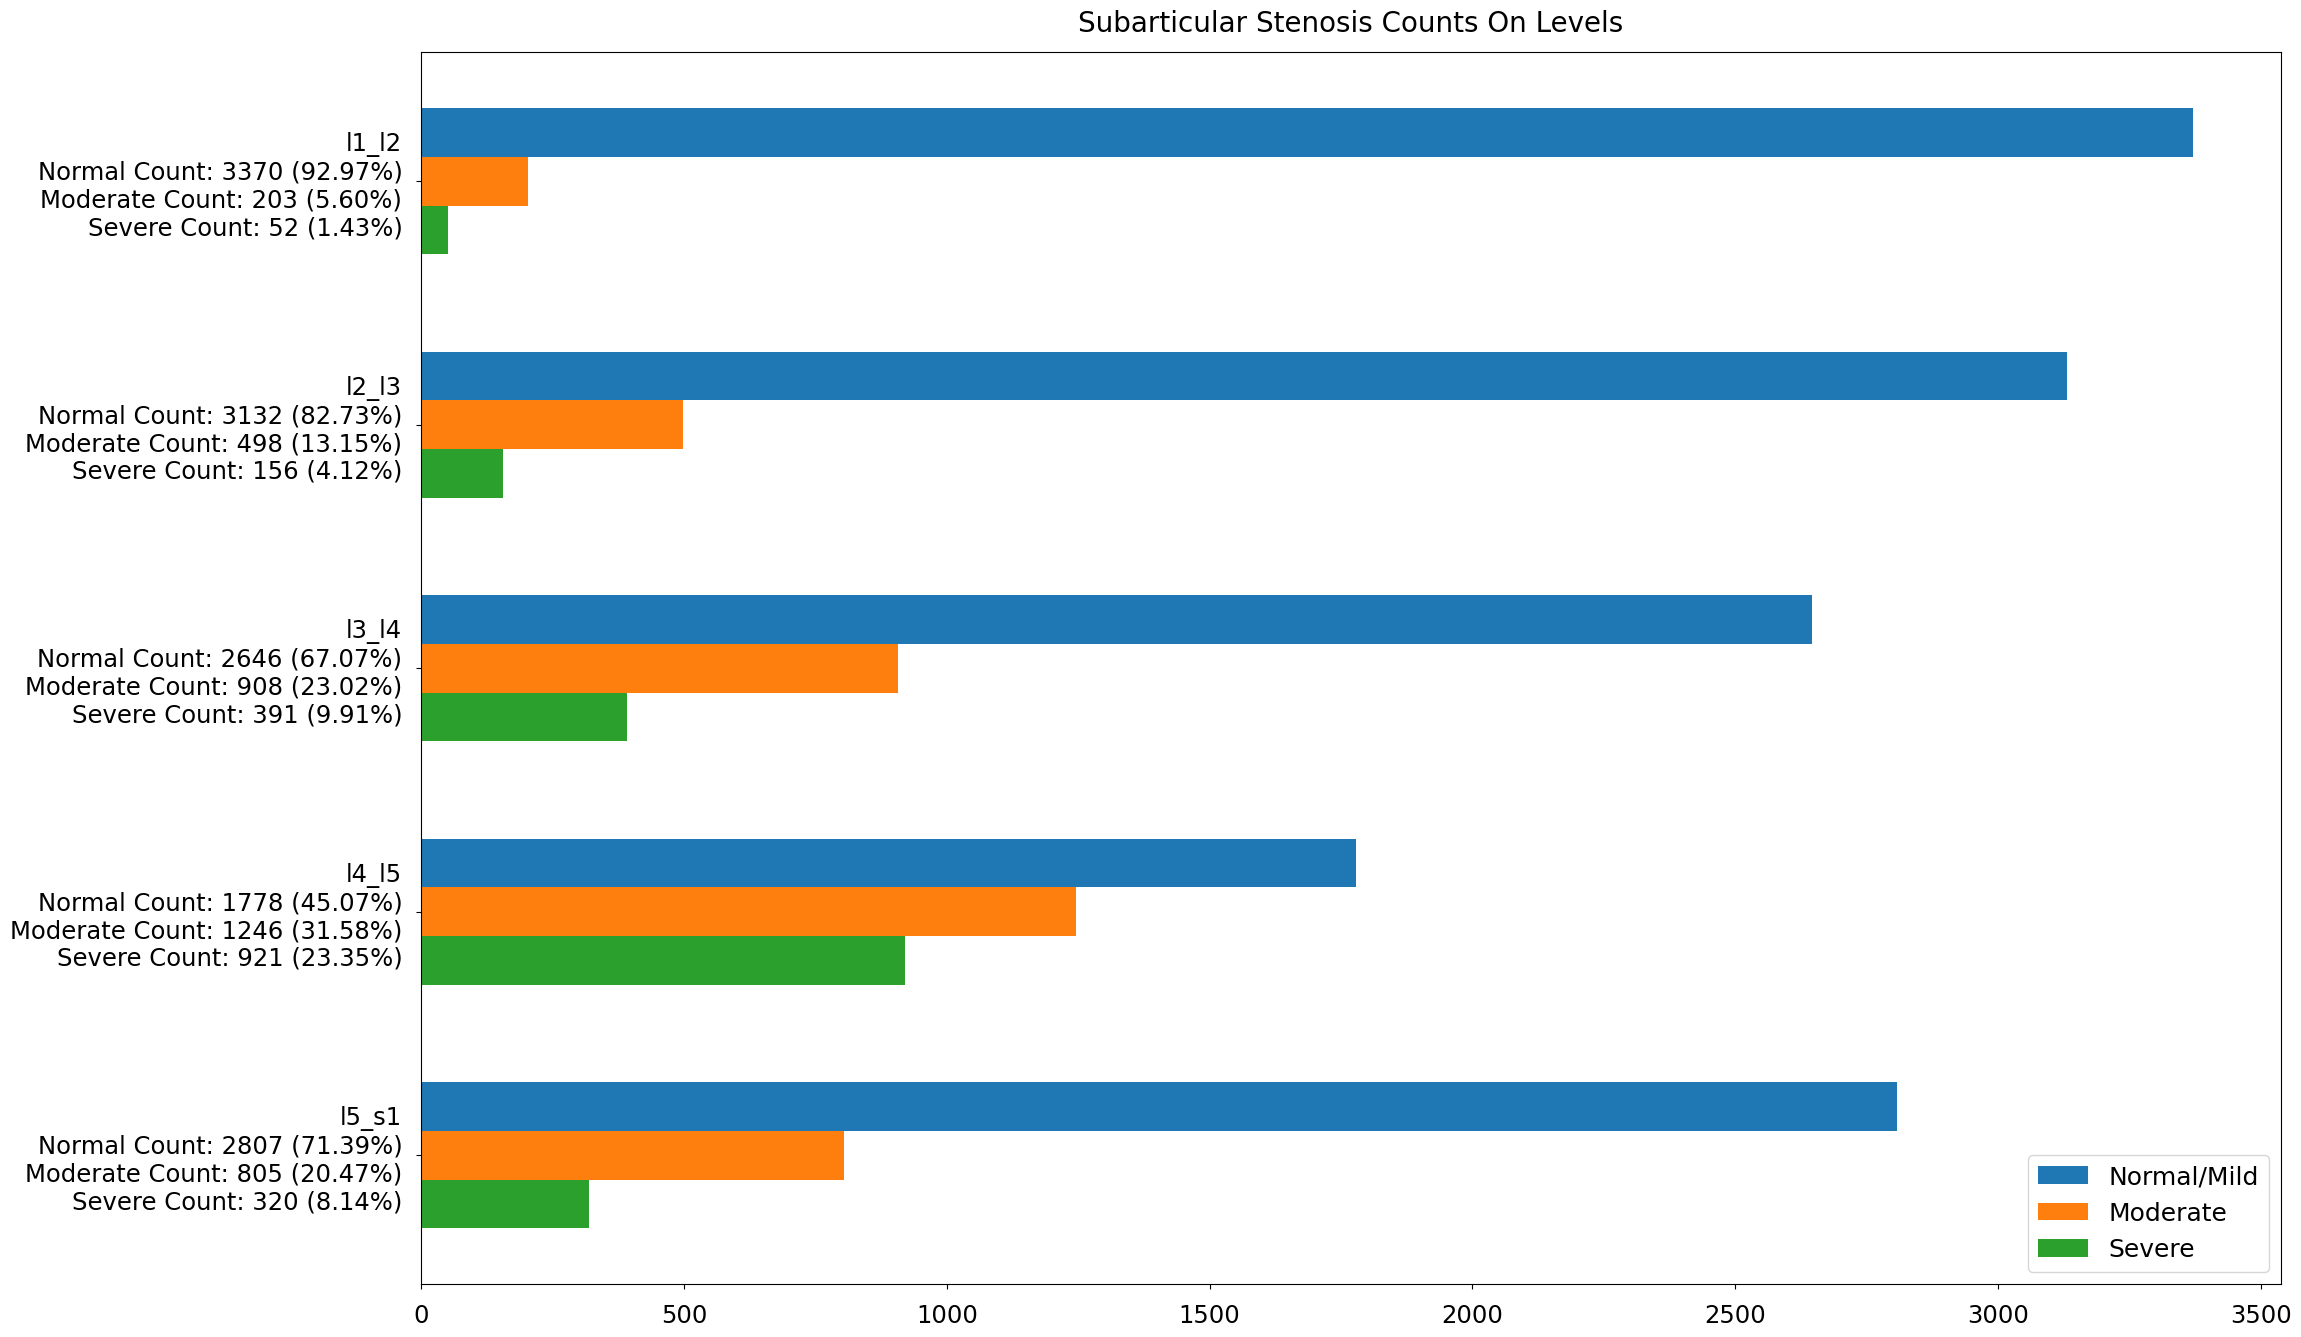

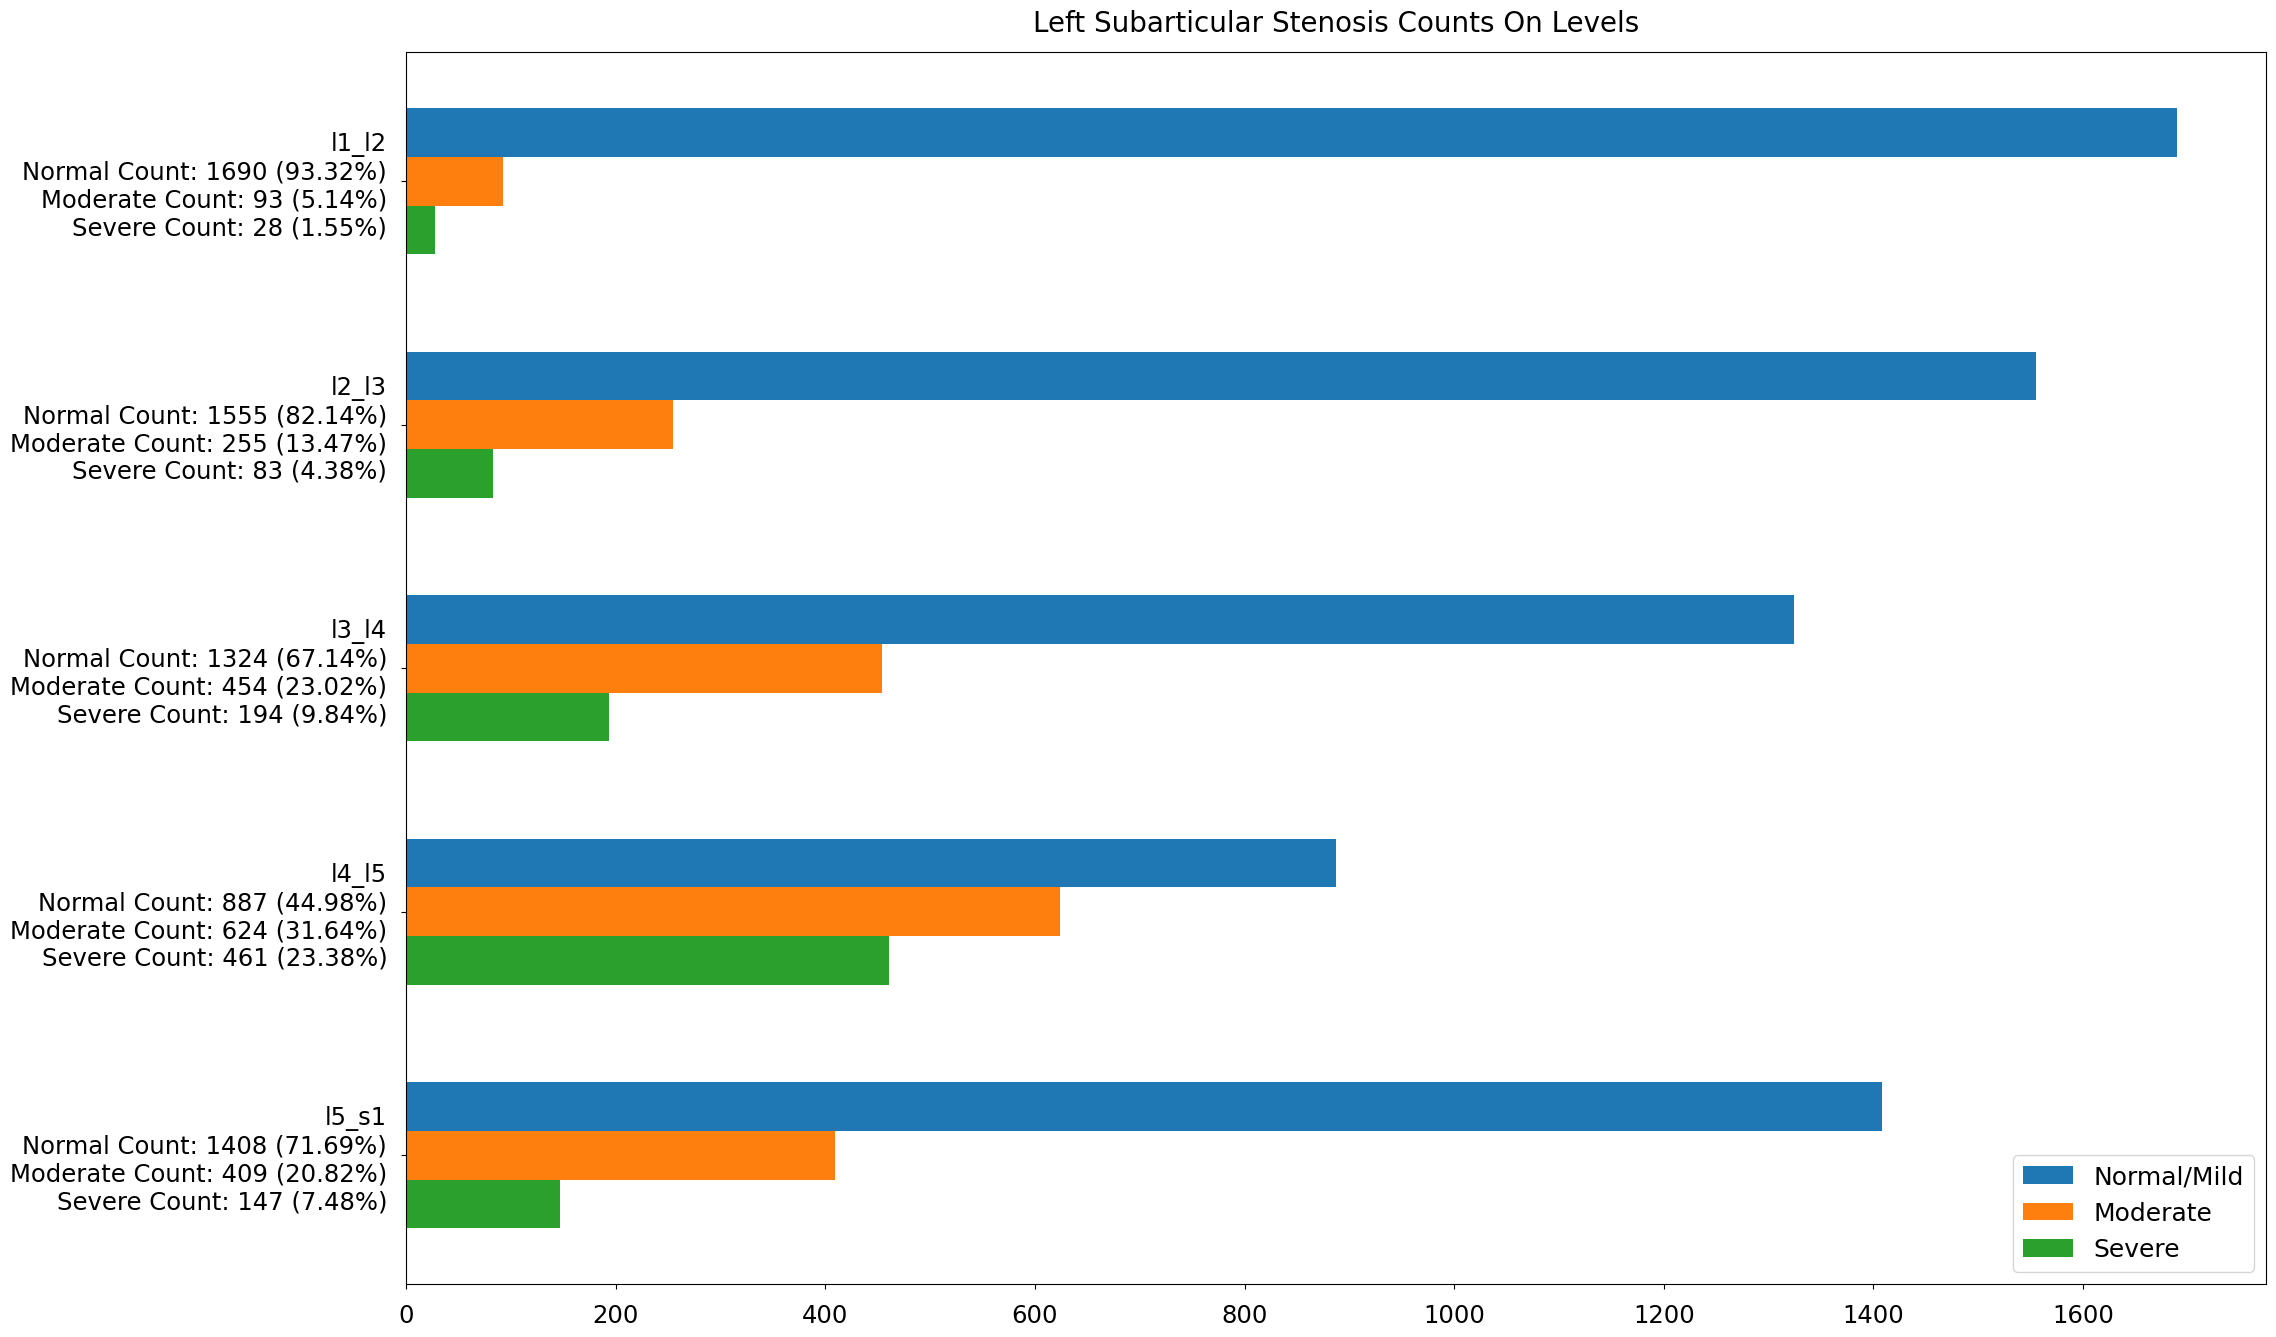

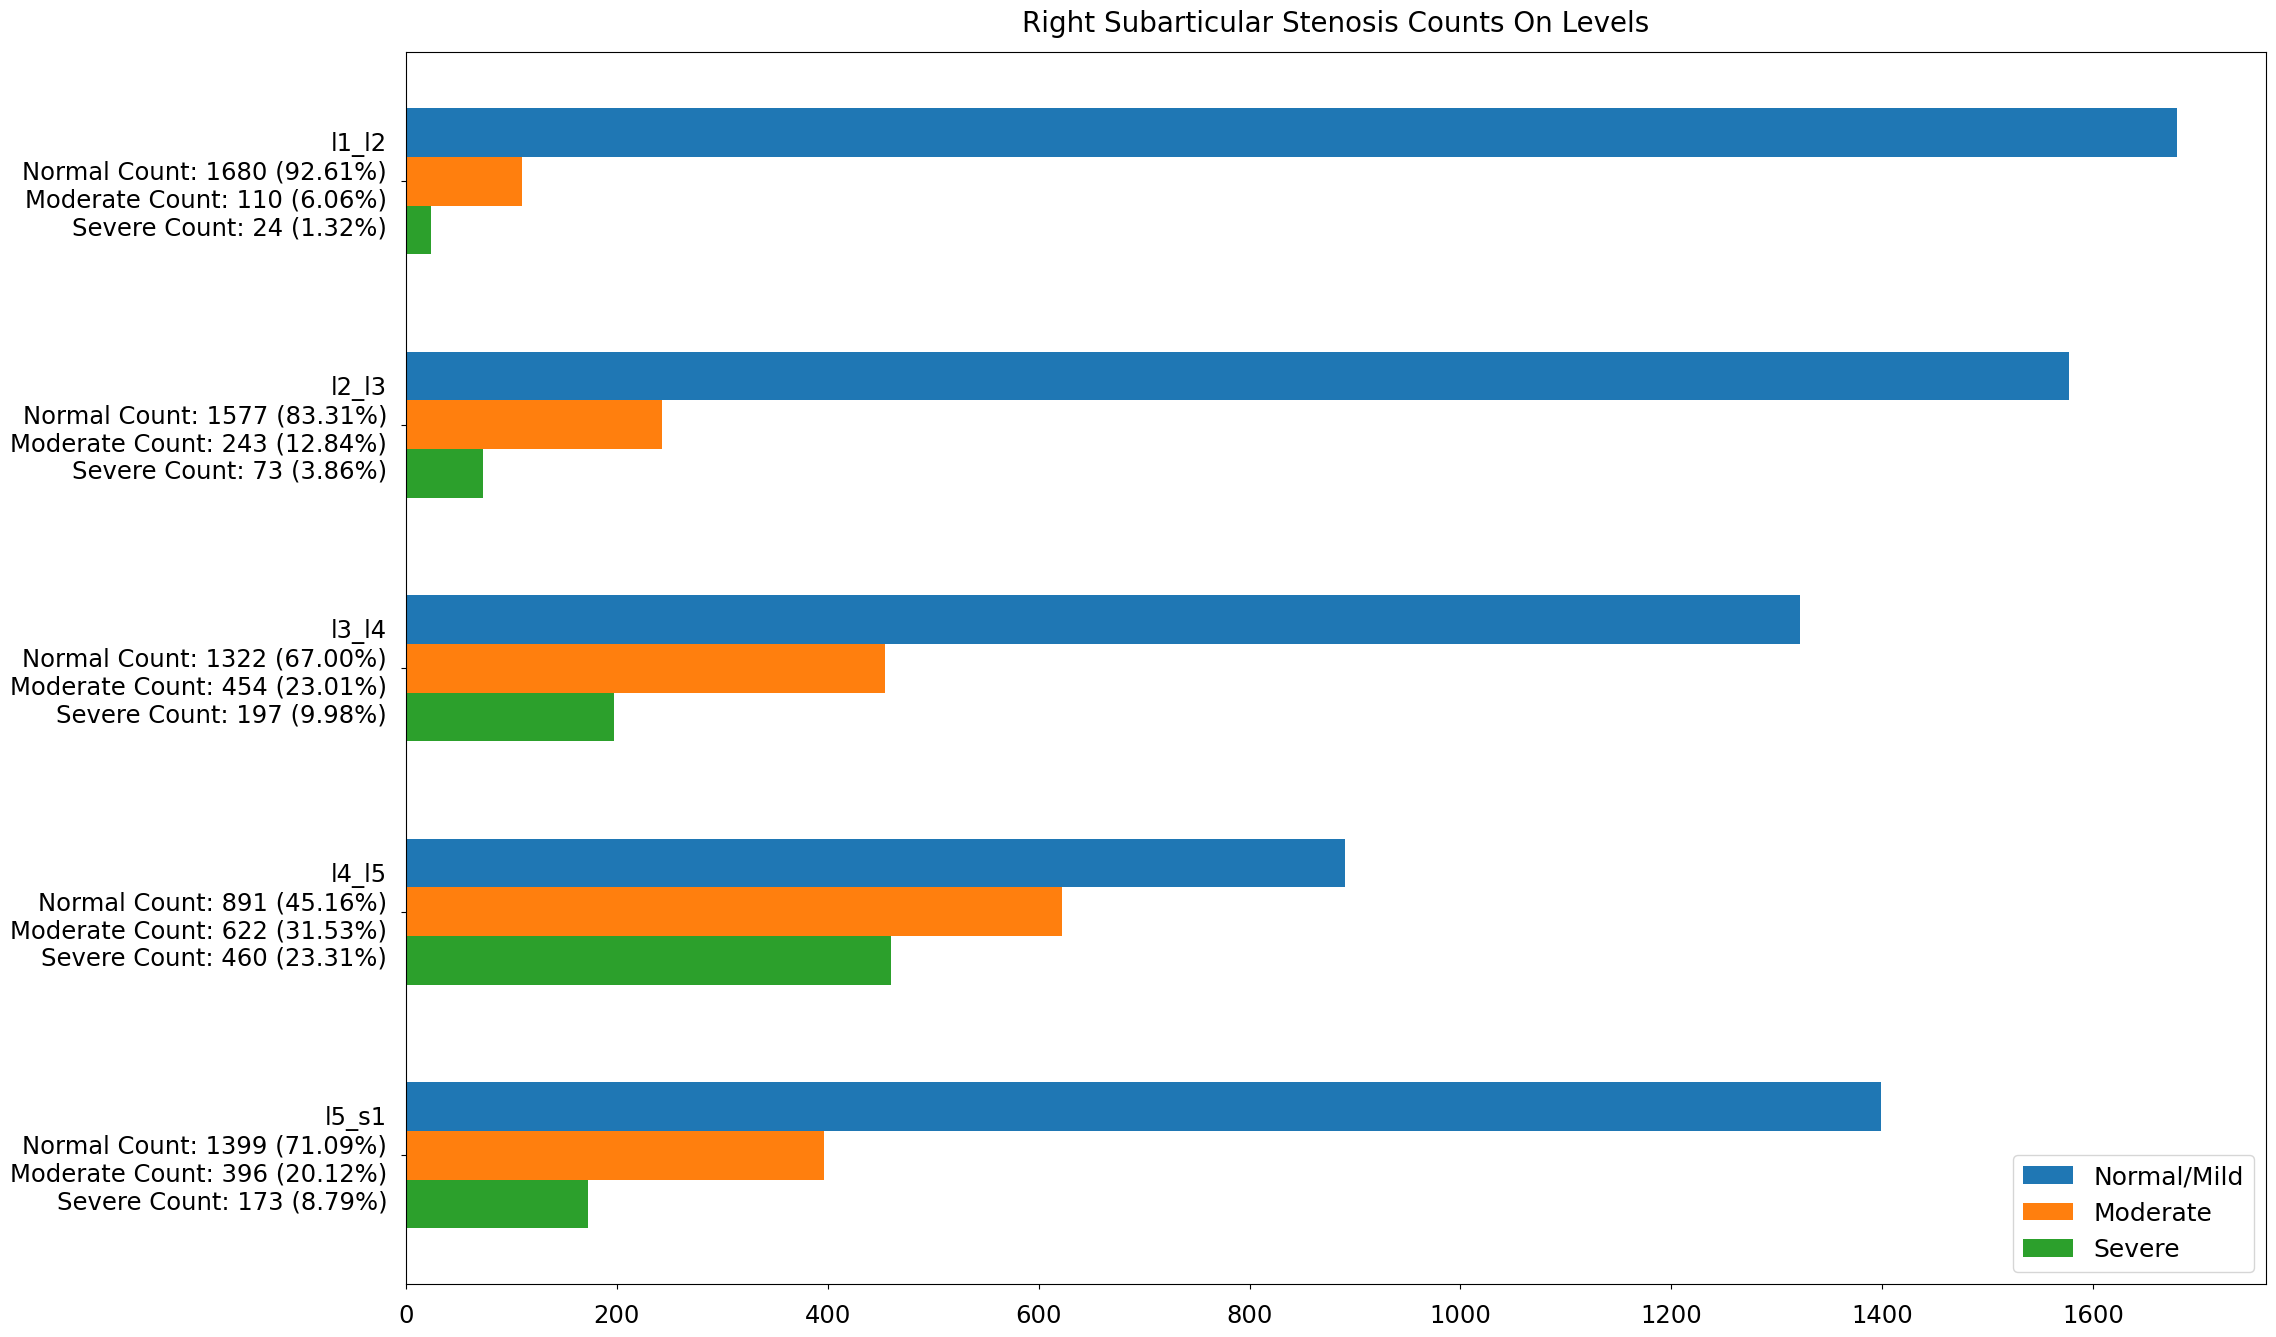

In [13]:
visualize_condition_counts(
    df=df_train_subarticular_stenosis_counts,
    title='Subarticular Stenosis Counts On Levels'
)

visualize_condition_counts(
    df=df_train_left_subarticular_stenosis_counts,
    title='Left Subarticular Stenosis Counts On Levels'
)

visualize_condition_counts(
    df=df_train_right_subarticular_stenosis_counts,
    title='Right Subarticular Stenosis Counts On Levels'
)

In [14]:
subarticular_stenosis_columns = [column for column in df_train.columns if 'subarticular_stenosis' in column]
df_train_left_right_subarticular_stenosis = []

for column in subarticular_stenosis_columns[:5]:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'left_subarticular_stenosis'})
    df_train_left_right_subarticular_stenosis.append(df)

for column in subarticular_stenosis_columns[5:]:
    df = df_train[[column]].copy(deep=True)
    df['level'] = '_'.join(column.split('_')[-2:])
    df = df.rename(columns={column: 'right_subarticular_stenosis'})
    df_train_left_right_subarticular_stenosis.append(df)
    
df_train_left_right_subarticular_stenosis = pd.concat((
    pd.concat(df_train_left_right_subarticular_stenosis[:5], axis=0).reset_index(drop=True).iloc[:, :1],
    pd.concat(df_train_left_right_subarticular_stenosis[5:], axis=0).reset_index(drop=True)
), axis=1, ignore_index=False)

df_train_left_right_subarticular_stenosis['left_severity'] = df_train_left_right_subarticular_stenosis['left_subarticular_stenosis'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_left_right_subarticular_stenosis['right_severity'] = df_train_left_right_subarticular_stenosis['right_subarticular_stenosis'].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})
df_train_left_right_subarticular_stenosis['level_'] = df_train_left_right_subarticular_stenosis['level'].map({
    'l1_l2': 0,
    'l2_l3': 1,
    'l3_l4': 2,
    'l4_l5': 3,
    'l5_s1': 4
})

Severity of left and right subarticular stenosis have correlation coefficient of 0.581 which shows that they are significantly correlated with each other.

In [15]:
df_subarticular_stenosis_correlations = df_train_left_right_subarticular_stenosis[['level_', 'left_severity', 'right_severity']].corr()
display(df_subarticular_stenosis_correlations)

,level_,left_severity,right_severity
level_,1.000000,0.236914,0.245518
left_severity,0.236914,1.000000,0.581930
right_severity,0.245518,0.581930,1.000000


### 3.4. Key Differences

![differences](https://i.ibb.co/GQBKgRG/stenosis.jpg)

* **Lateral (Subarticular) Stenosis**:
    * Narrowing happens in the lateral recess or subarticular space, which is part of the spinal canal but closer to the sides
    * Specifically affects the area beneath the facet joints where nerve roots travel before exiting the spine
    

* **Spinal Canal (Central) Stenosis**:
    * Narrowing occurs in the central spinal canal, where the spinal cord or cauda equina (in the lumbar spine) is located
    * Affects the main passageway through which the spinal cord and nerves travel


* **Foraminal Stenosis**:
    * Narrowing occurs in the neural foramina, the openings on either side of the vertebrae through which nerve roots exit the spinal column
    * Directly affects the spaces through which the nerves exit the spinal canal and extend to other parts of the body

## 4. Missing Values

Missing values exist on all conditions and counts of them are listed below.

* **spinal_canal_stenosis_l1_l2**: 1
* **spinal_canal_stenosis_l2_l3**: 1
* **spinal_canal_stenosis_l3_l4**: 1
* **spinal_canal_stenosis_l4_l5**: 1
* **spinal_canal_stenosis_l5_s1**: 1
* **left_neural_foraminal_narrowing_l1_l2**: 2
* **left_neural_foraminal_narrowing_l2_l3**: 2
* **left_neural_foraminal_narrowing_l3_l4**: 2
* **left_neural_foraminal_narrowing_l4_l5**: 2
* **left_neural_foraminal_narrowing_l5_s1**: 2
* **right_neural_foraminal_narrowing_l1_l2**: 8
* **right_neural_foraminal_narrowing_l2_l3**: 8
* **right_neural_foraminal_narrowing_l3_l4**: 8
* **right_neural_foraminal_narrowing_l4_l5**: 8
* **right_neural_foraminal_narrowing_l5_s1**: 8
* **left_subarticular_stenosis_l1_l2**: 164
* **left_subarticular_stenosis_l2_l3**: 82
* **left_subarticular_stenosis_l3_l4**: 3
* **left_subarticular_stenosis_l4_l5**: 3
* **left_subarticular_stenosis_l5_s1**: 11
* **right_subarticular_stenosis_l1_l2**: 161
* **right_subarticular_stenosis_l2_l3**: 82
* **right_subarticular_stenosis_l3_l4**: 2
* **right_subarticular_stenosis_l4_l5**: 2
* **right_subarticular_stenosis_l5_s1**: 7

There are very few missing values on spinal canal stenosis (1) and neural foraminal narrowing (left 2 and right 8). They are consistently missing on all levels so incomplete labels may not be related to lowest vertebrae being not visible on those studies.

There are more missing values on subarticular stenosis compared to other two conditions and, missing value counts vary between levels. They decrease along with levels so it's not related to lowest vertebrae being not visible either. Missing value counts are consistent between left and right for this condition.

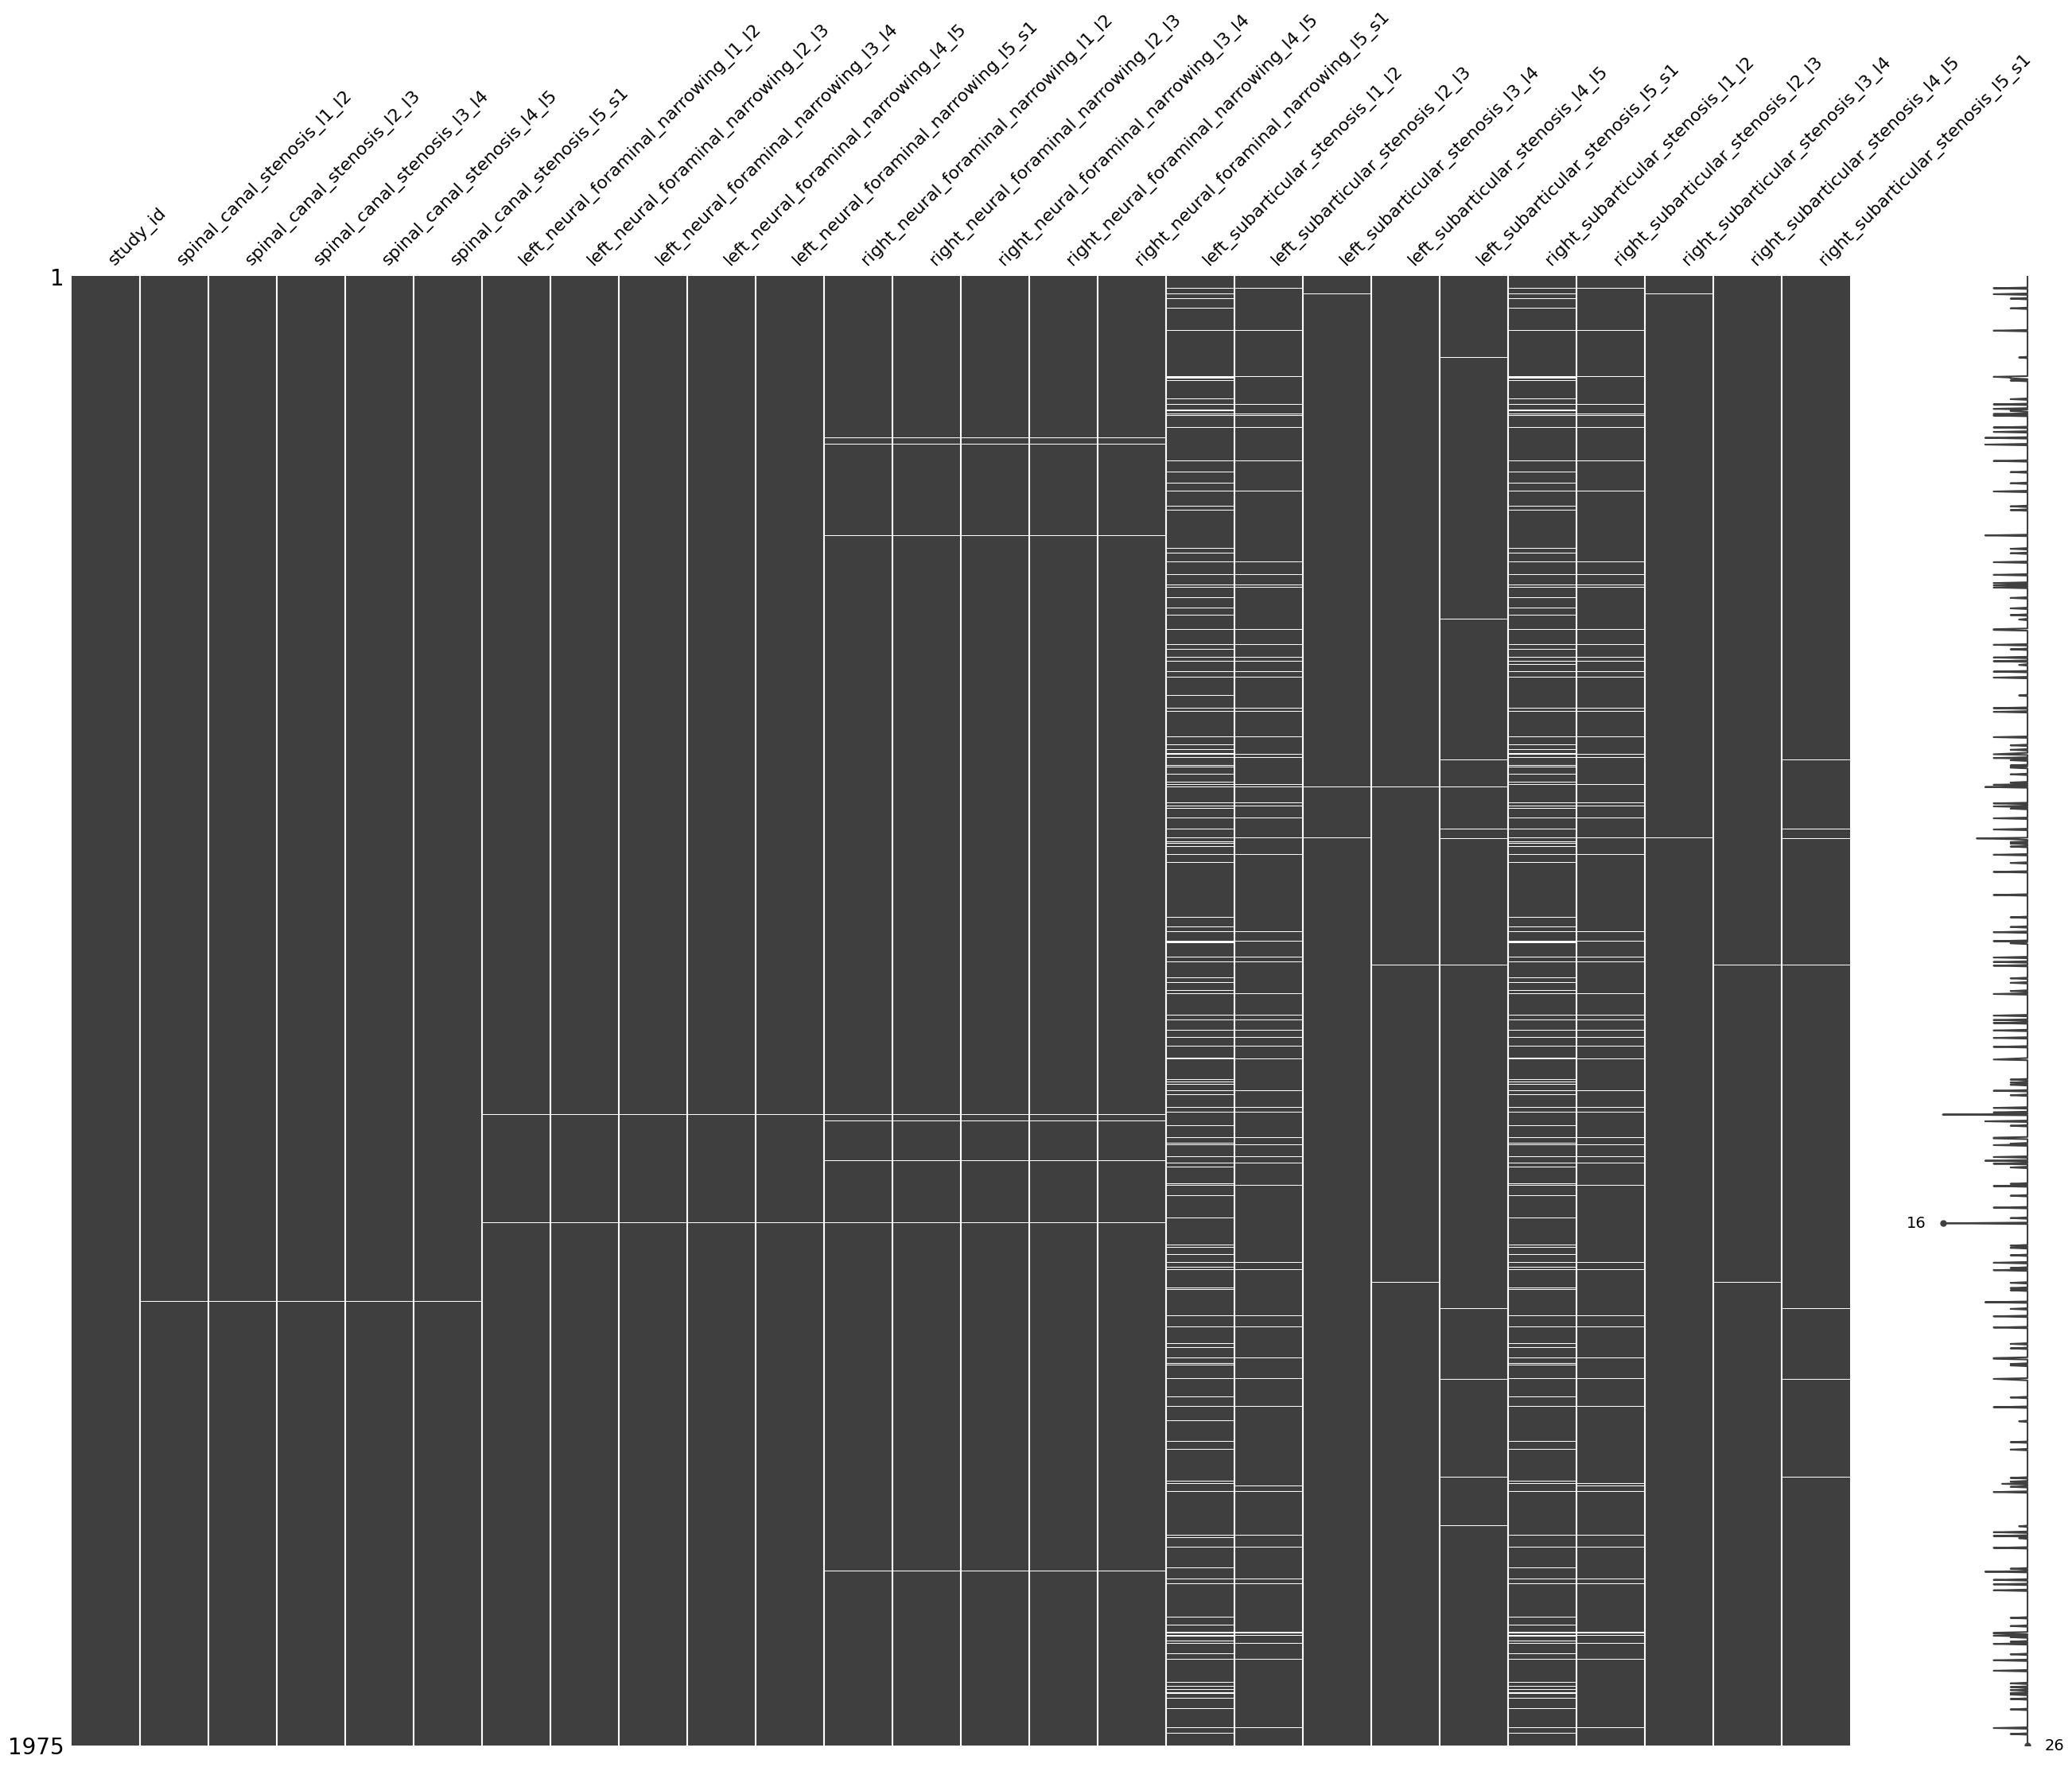

In [16]:
msno.matrix(df_train, figsize=(32, 24))
plt.show()

Dependencies of missing values can be seen more clearly on the dendrogram below. There are 8 groups that are formed:
* Spinal canal stenosis missing values on all levels
* Left neural foraminal narrowing missing values on all levels
* Right neural foraminal narrowing missing values on all levels
* Left and right subarticular stenosis missing values on l1_l2
* Left and right subarticular stenosis missing values on l2_l3
* Left and right subarticular stenosis missing values on l3_l4
* Left and right subarticular stenosis missing values on l4_l5
* Left and right subarticular stenosis missing values on l5_s1

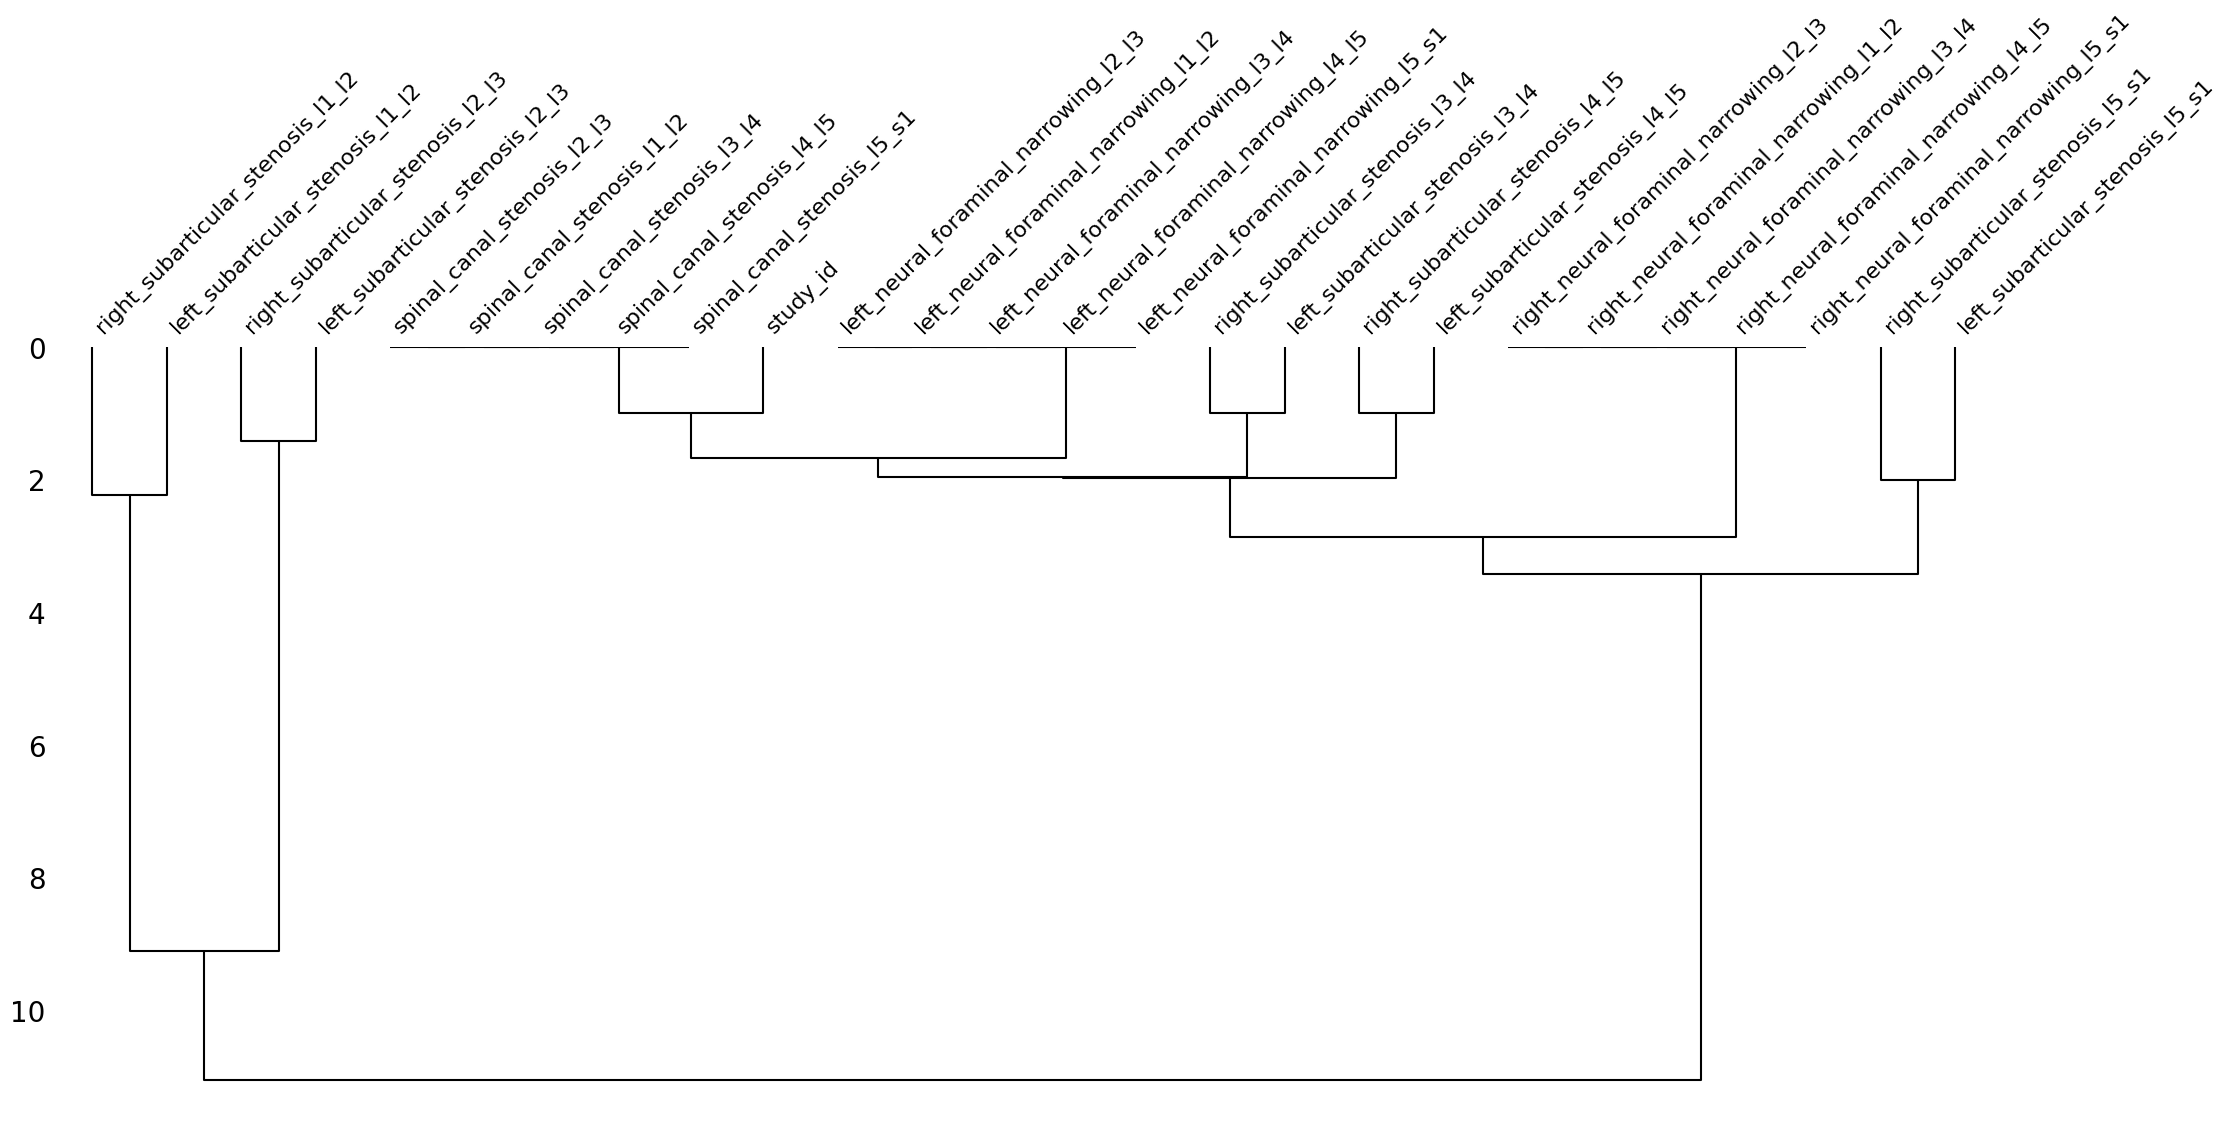

In [17]:
msno.dendrogram(df_train)
plt.show()

## 5. Modalities and Planes

MRI (Magnetic Resonance Imaging) modalities refer to the different techniques and sequences used during a scan to capture images of the body's internal structures. An MRI plane refers to the specific orientation or direction in which the images are taken during a scan.

MRI imaging modalities and planes of series are provided in `train_series_descriptions.csv` file. Number of series in studies can be obtained from that data too.

In [18]:
train_series = glob(str(competition_dataset_directory / 'train_images' / '*' / '*'))

print(f'Train Series Descriptions Shape: {df_train_series_descriptions.shape}')
print(f'Train Series Count {len(train_series)}')

display(df_train_series_descriptions)

Train Series Descriptions Shape: (6294, 3)
Train Series Count 6294


,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


In [19]:
def visualize_counts(df, value, title, path=None):
    
    """
    Visualize counts on training set
    
    Parameters
    ----------
    df: pandas.DataFrame
        Counts and percentages of conditions
        
    title: str
        Title of the plot
        
    path: str, pathlib.Path or None
        Path of the output file (if path is None, plot is displayed with selected backend)
    """
    
    fig, ax = plt.subplots(figsize=(24, 16))

    ax.barh(
        y=np.arange(df.shape[0]),
        width=df['count'].values,
        align='center'
    )

    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_yticklabels([
        f'{val} - Count: {count} ({percentage:.2f}%)' for val, count, percentage in zip(
            df[value].values,
            df['count'].values,
            df['percentage'].values,
        )
    ])
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=17.5, pad=10)
    ax.tick_params(axis='y', labelsize=17.5, pad=10)
    ax.set_title(title, size=20, pad=15)
    ax.legend(loc='best', prop={'size': 18})
    plt.gca().invert_yaxis()

    plt.show()

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


In [20]:
df_train_series_counts = df_train_series_descriptions.groupby('study_id')['series_id'].count().value_counts().reset_index().rename(columns={'series_id': 'series_count'})
df_train_series_counts['percentage'] = df_train_series_counts['count'] / df_train_series_counts['count'].sum(axis=0) * 100

Number of series in studies can be between 2 and 6, but more than 98% of the studies have 3 or 4 series. Other than that, there are 30 studies that have 5 series, 3 studies that have 2 series and 1 study that has 6 series. 

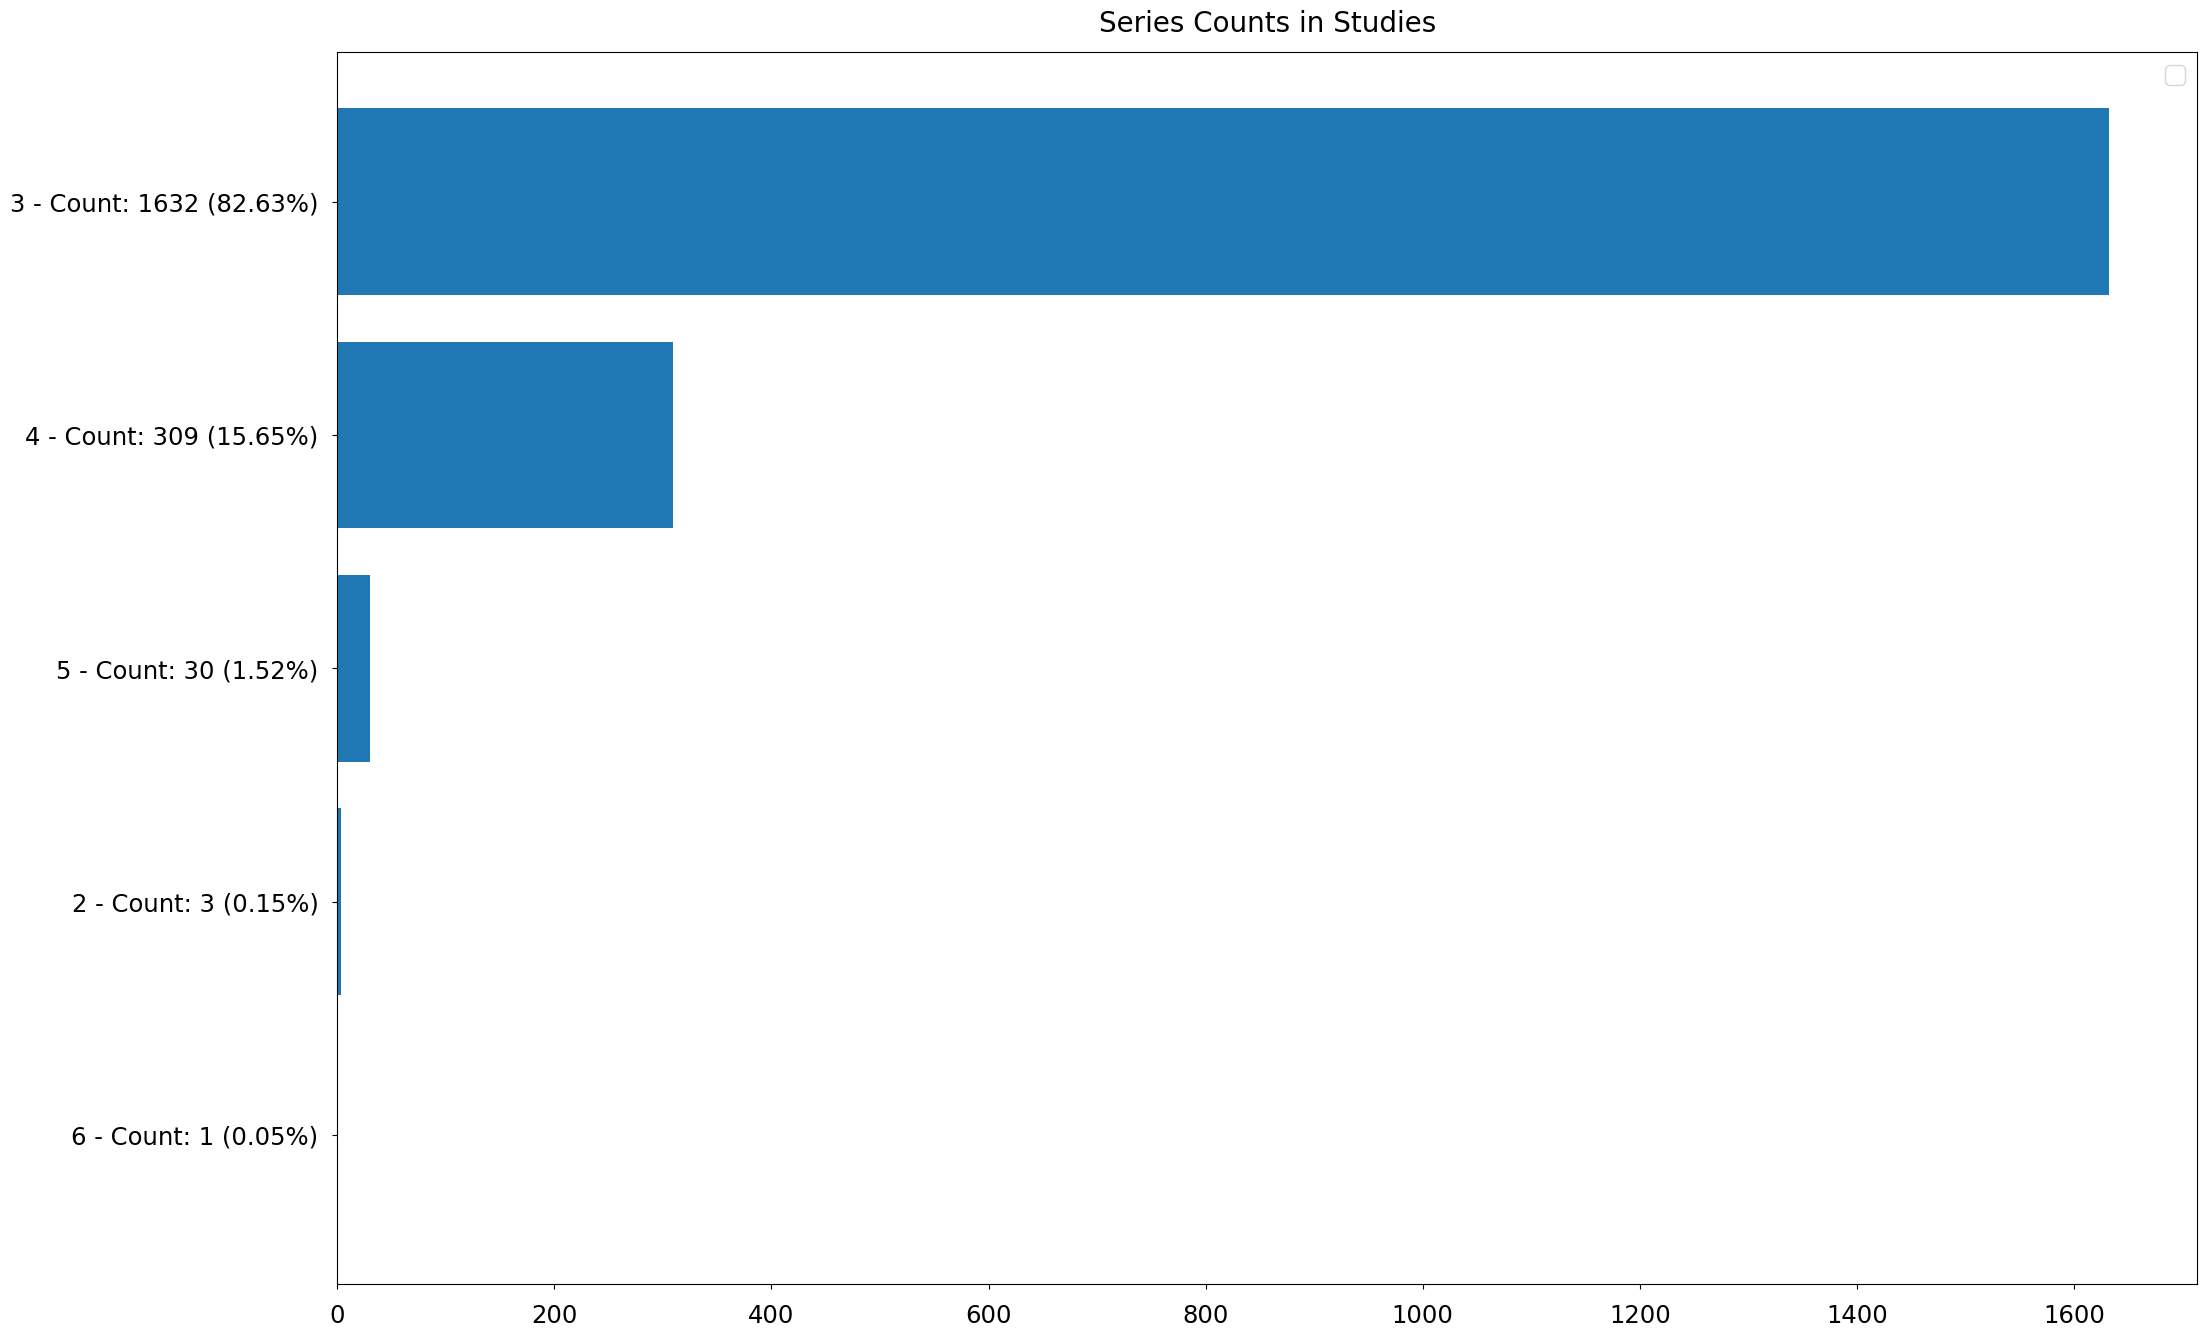

In [21]:
visualize_counts(df=df_train_series_counts, value='series_count', title='Series Counts in Studies')

In [22]:
df_train_series_descriptions['plane'] = df_train_series_descriptions['series_description'].apply(lambda x: str(x).split()[0].strip())
df_train_series_descriptions['modality'] = df_train_series_descriptions['series_description'].apply(lambda x: str(x).split()[-1].strip())

df_train_series_description_counts = df_train_series_descriptions['series_description'].value_counts().reset_index()
df_train_series_description_counts['percentage'] = df_train_series_description_counts['count'] / df_train_series_description_counts['count'].sum(axis=0) * 100

df_train_series_plane_counts = df_train_series_descriptions['plane'].value_counts().reset_index()
df_train_series_plane_counts['percentage'] = df_train_series_plane_counts['count'] / df_train_series_plane_counts['count'].sum(axis=0) * 100

df_train_series_modality_counts = df_train_series_descriptions['modality'].value_counts().reset_index()
df_train_series_modality_counts['percentage'] = df_train_series_modality_counts['count'] / df_train_series_modality_counts['count'].sum(axis=0) * 100

There are three unique MRI modalities in the dataset and they are **T1-weighted imaging (T1)**, **T2-weighted imaging (T2)**, and **T2-weighted imaging with Short Tau Inversion Recovery (T2/STIR)**.

&nbsp;

#### 1. T1-Weighted Imaging (T1):

**Characteristics**:
* High-resolution anatomical detail: Provides clear images of the body's structure
* Contrast: Good for visualizing fat and differentiating between different types of tissues

**Uses**:
* Anatomical details: Excellent for assessing normal anatomy and identifying structural abnormalities
* Pathologies: Useful for detecting fat, subacute hemorrhage, and certain lesions
* Post-contrast imaging: Often used with gadolinium contrast agents to highlight blood vessels and tumors

**Appearance**:
* Fat: Appears bright
* Water: Appears dark
* Muscle and other soft tissues: Intermediate signal intensity

**Applications**:
* Brain: Differentiating gray matter from white matter, identifying hemorrhages
* Spine: Assessing vertebral bodies and disc spaces
* Abdomen: Visualizing organs and detecting fatty liver disease

&nbsp;

#### 2. T2-Weighted Imaging (T2)

**Characteristics**:
* Fluid-sensitive: Highlights fluid-containing structures
* Pathological contrast: Effective for detecting a wide range of pathologies involving water content

**Uses**:
* Pathologies: Excellent for identifying edema, inflammation, and tumors
* Conditions: Commonly used to detect cysts, abscesses, and degenerative changes

**Appearance**:
* Water and fluid: Appear bright
* Fat: Less bright compared to T1-weighted images
* Muscle and other soft tissues: Intermediate to dark signal intensity

**Applications**:
* Brain: Detecting lesions, edema, and demyelinating diseases
* Spine: Identifying disc herniations, spinal stenosis, and other degenerative conditions
* Joints: Assessing joint effusions and cartilage integrity

&nbsp;

#### 3. T2-Weighted Imaging with Short Tau Inversion Recovery (T2/STIR)

**Characteristics**:
* Fat suppression: Specifically suppresses the signal from fat, making it easier to see fluid-related pathologies
* Enhanced contrast: Improves the visibility of edema and inflammation

**Uses**:
* Pathologies: Especially useful for detecting edema, inflammation, and bone marrow abnormalities
* Musculoskeletal imaging: Commonly used to evaluate muscles, tendons, ligaments, and bone marrow

**Appearance**:
* Water and fluid: Appear bright
* Fat: Suppressed and appears dark
* Muscle and other soft tissues: Intermediate signal intensity

**Applications**:
* Spine: Assessing bone marrow edema and soft tissue abnormalities
* Musculoskeletal system: Evaluating injuries such as sprains, strains, and muscle tears
* Oncology: Detecting tumors and assessing their extent

&nbsp;

These MRI modalities provide complementary information, allowing for a comprehensive assessment of various medical conditions. They can be seen on the image below; T1 (A), T2 (B) and T2/STIR (C).

![modalities](https://i.ibb.co/7GWDc0f/T1-weighted-A-T2-weighted-B-and-STIR-weighted-C-mid-sagittal-images-of-a-58-years.png)

&nbsp;

Their counts and percentages within the dataset are visualized below. Since more than 98% of the studies have 3 or 4 series, modalities are somewhat equally distributed.

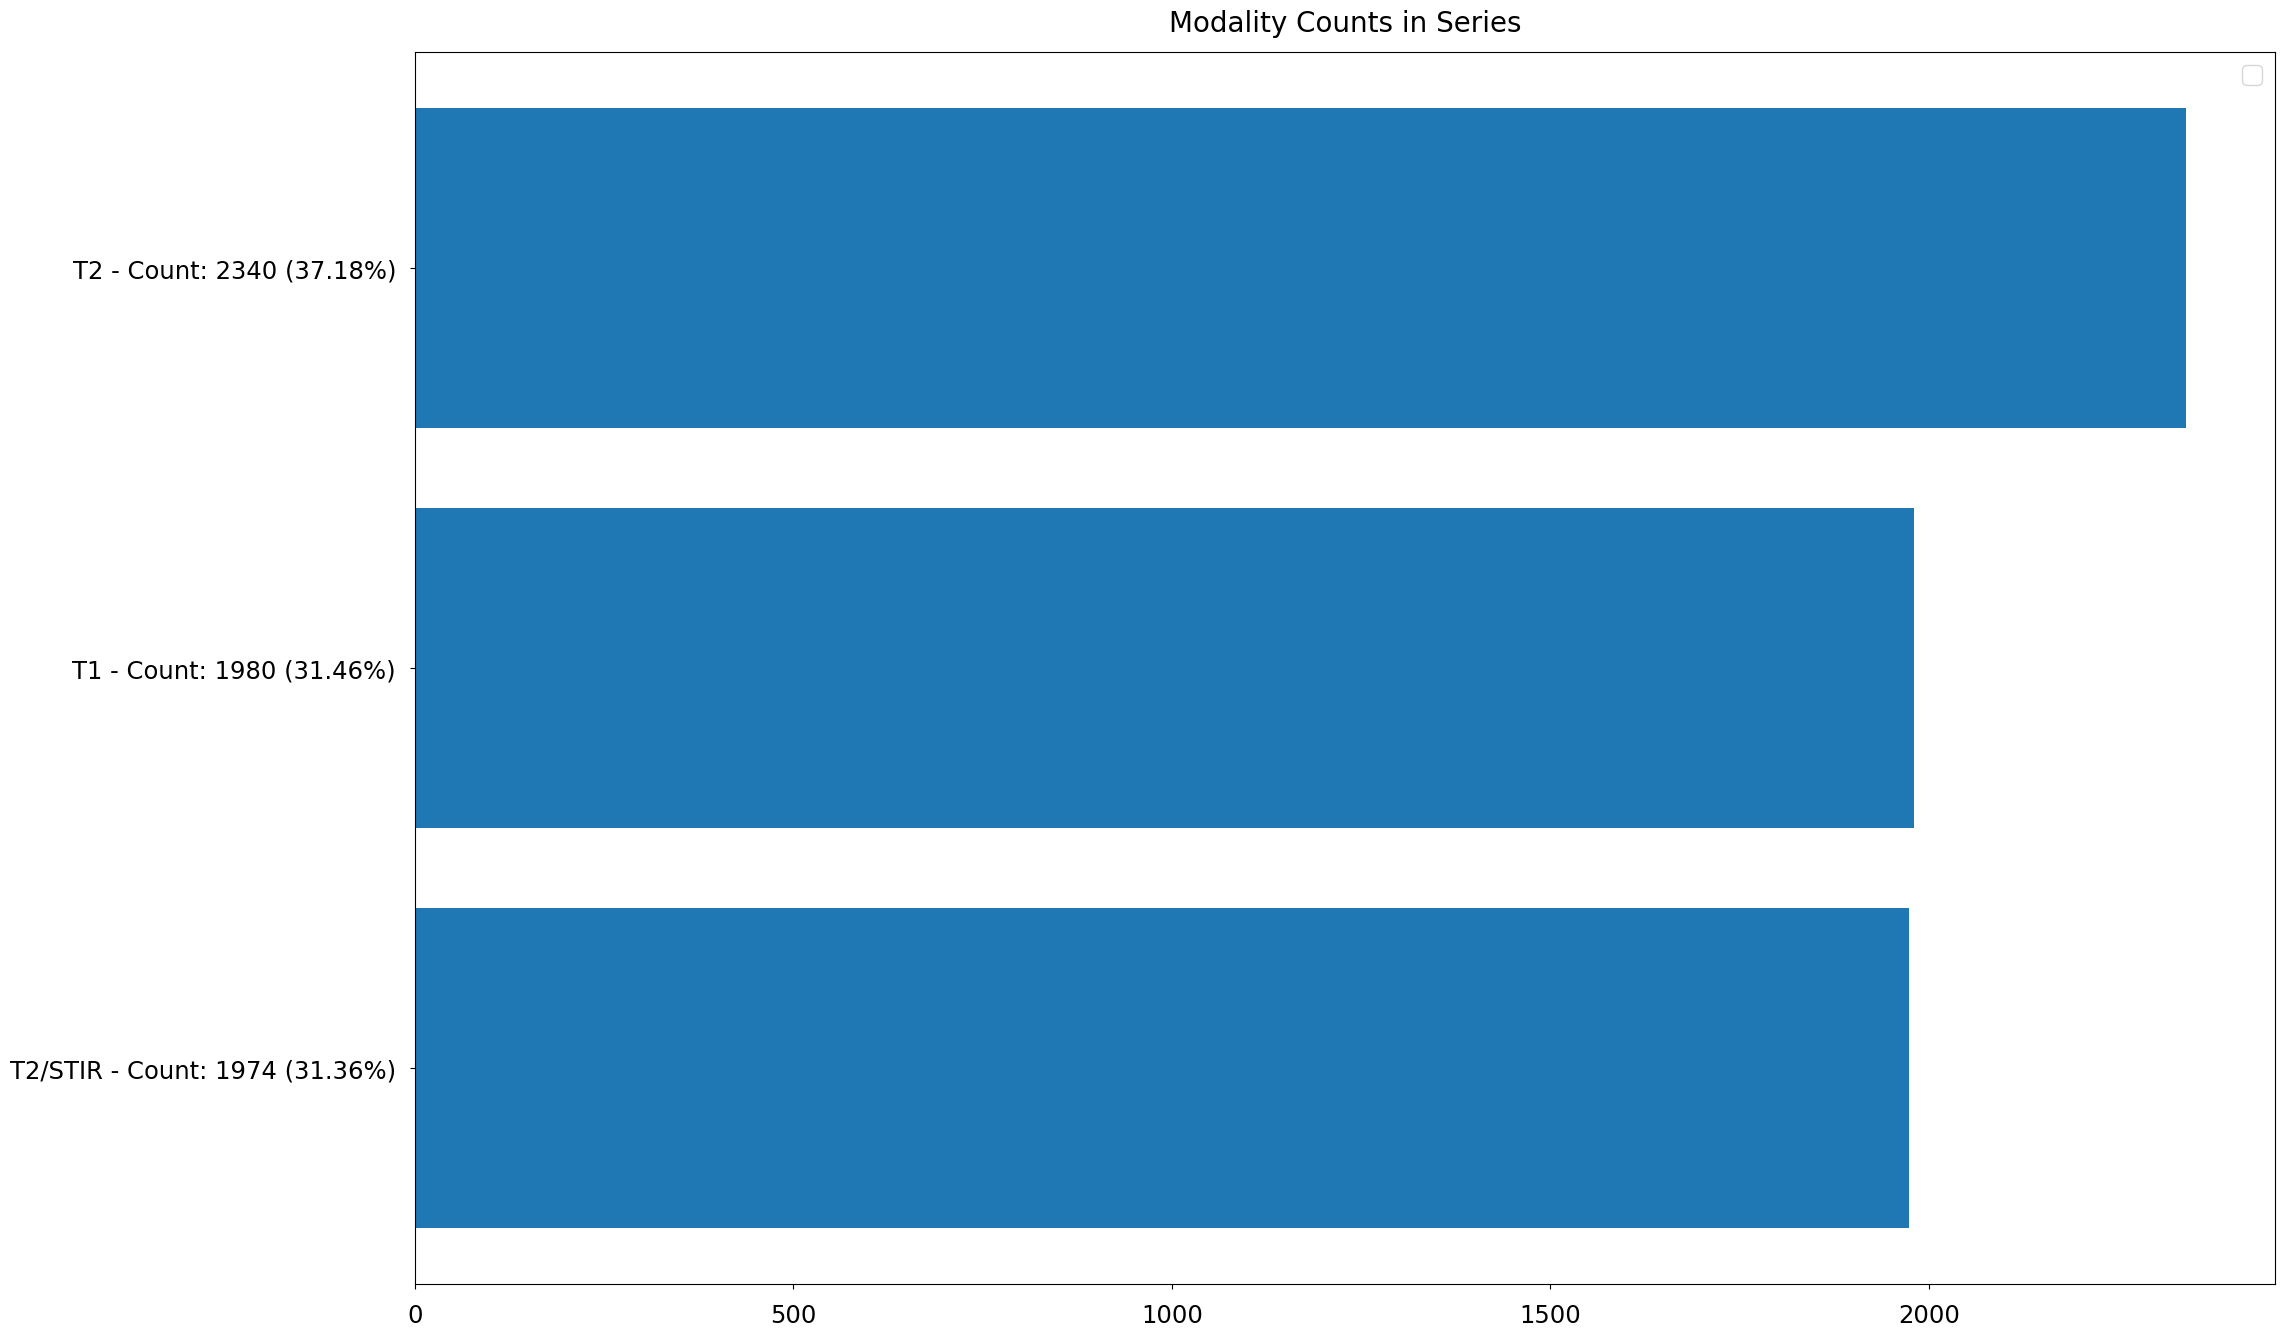

In [23]:
visualize_counts(df=df_train_series_modality_counts, value='modality', title='Modality Counts in Series')

There are two unique planes in the dataset and they are **Sagittal**, and **Axial**. There is also another plane named **Coronal** but none of the MRIs are given in that plane.

&nbsp;

#### 1. Sagittal Plane:

* **Description**: This plane divides the body into left and right sections
* **Orientation**: Images are taken from the side, as if you are looking at the body from the side
* **Common Uses**:
    * Useful for viewing structures along the midline of the body, such as the spine, brain, and joints
    * Helps in assessing the alignment and relationships of structures from front to back

&nbsp;

#### 2. Axial Plane:

* **Description**: This plane divides the body into upper (superior) and lower (inferior) sections
* **Orientation**: Images are taken as if you are looking up from the feet or down from the head, providing horizontal slices of the body
* **Common Uses**:
    * Commonly used to view the brain, spine, abdomen, and pelvis
    * Allows for the examination of cross-sectional anatomy, making it easier to detect abnormalities such as tumors, lesions, or injuries

&nbsp;

#### 3. Coronal Plane:

* **Description**: This plane divides the body into front (anterior) and back (posterior) sections
* **Orientation**: Images are taken from the front or back, as if you are looking at the body straight on
* **Common Uses**:
    * Useful for visualizing the frontal view of organs and structures, such as the brain, heart, lungs, and abdominal organs 
    * Helps in assessing the symmetry and positioning of structures

&nbsp;

Those planes can be seen on the image below; Sagittal (A), Coronal (B) and Axial (C).

![planes](https://i.ibb.co/P15mYbT/planes.png)

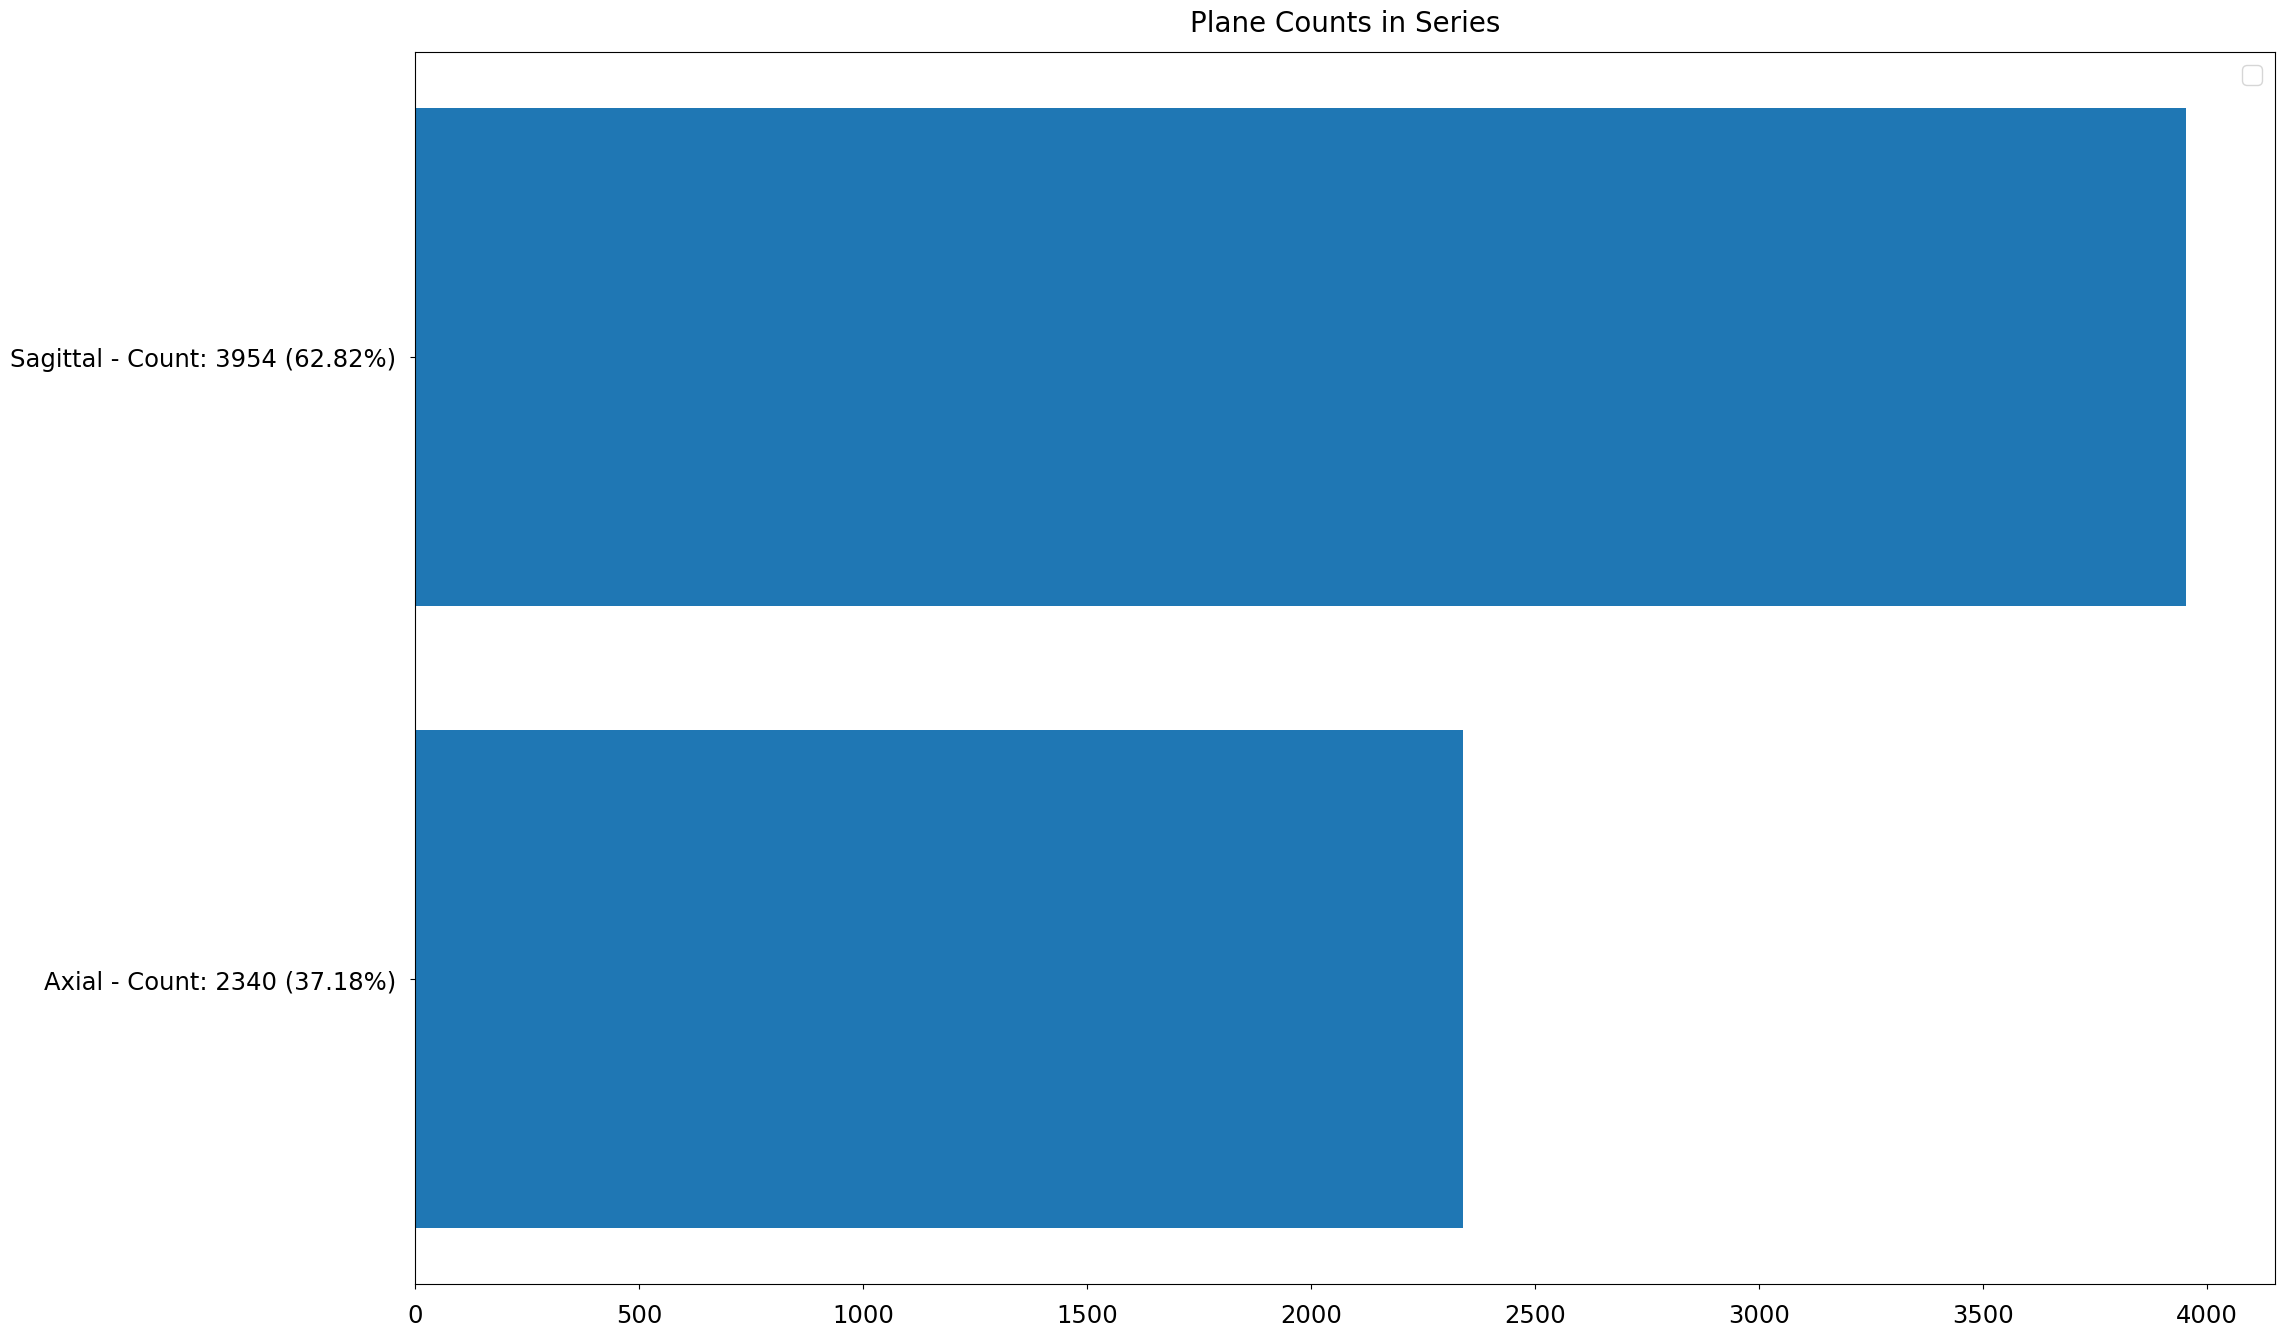

In [24]:
visualize_counts(df=df_train_series_plane_counts, value='plane', title='Plane Counts in Series')

Finally, the counts and percentages of plane and modality combinations are visualized below. It is identical to counts and percentages of modalities.

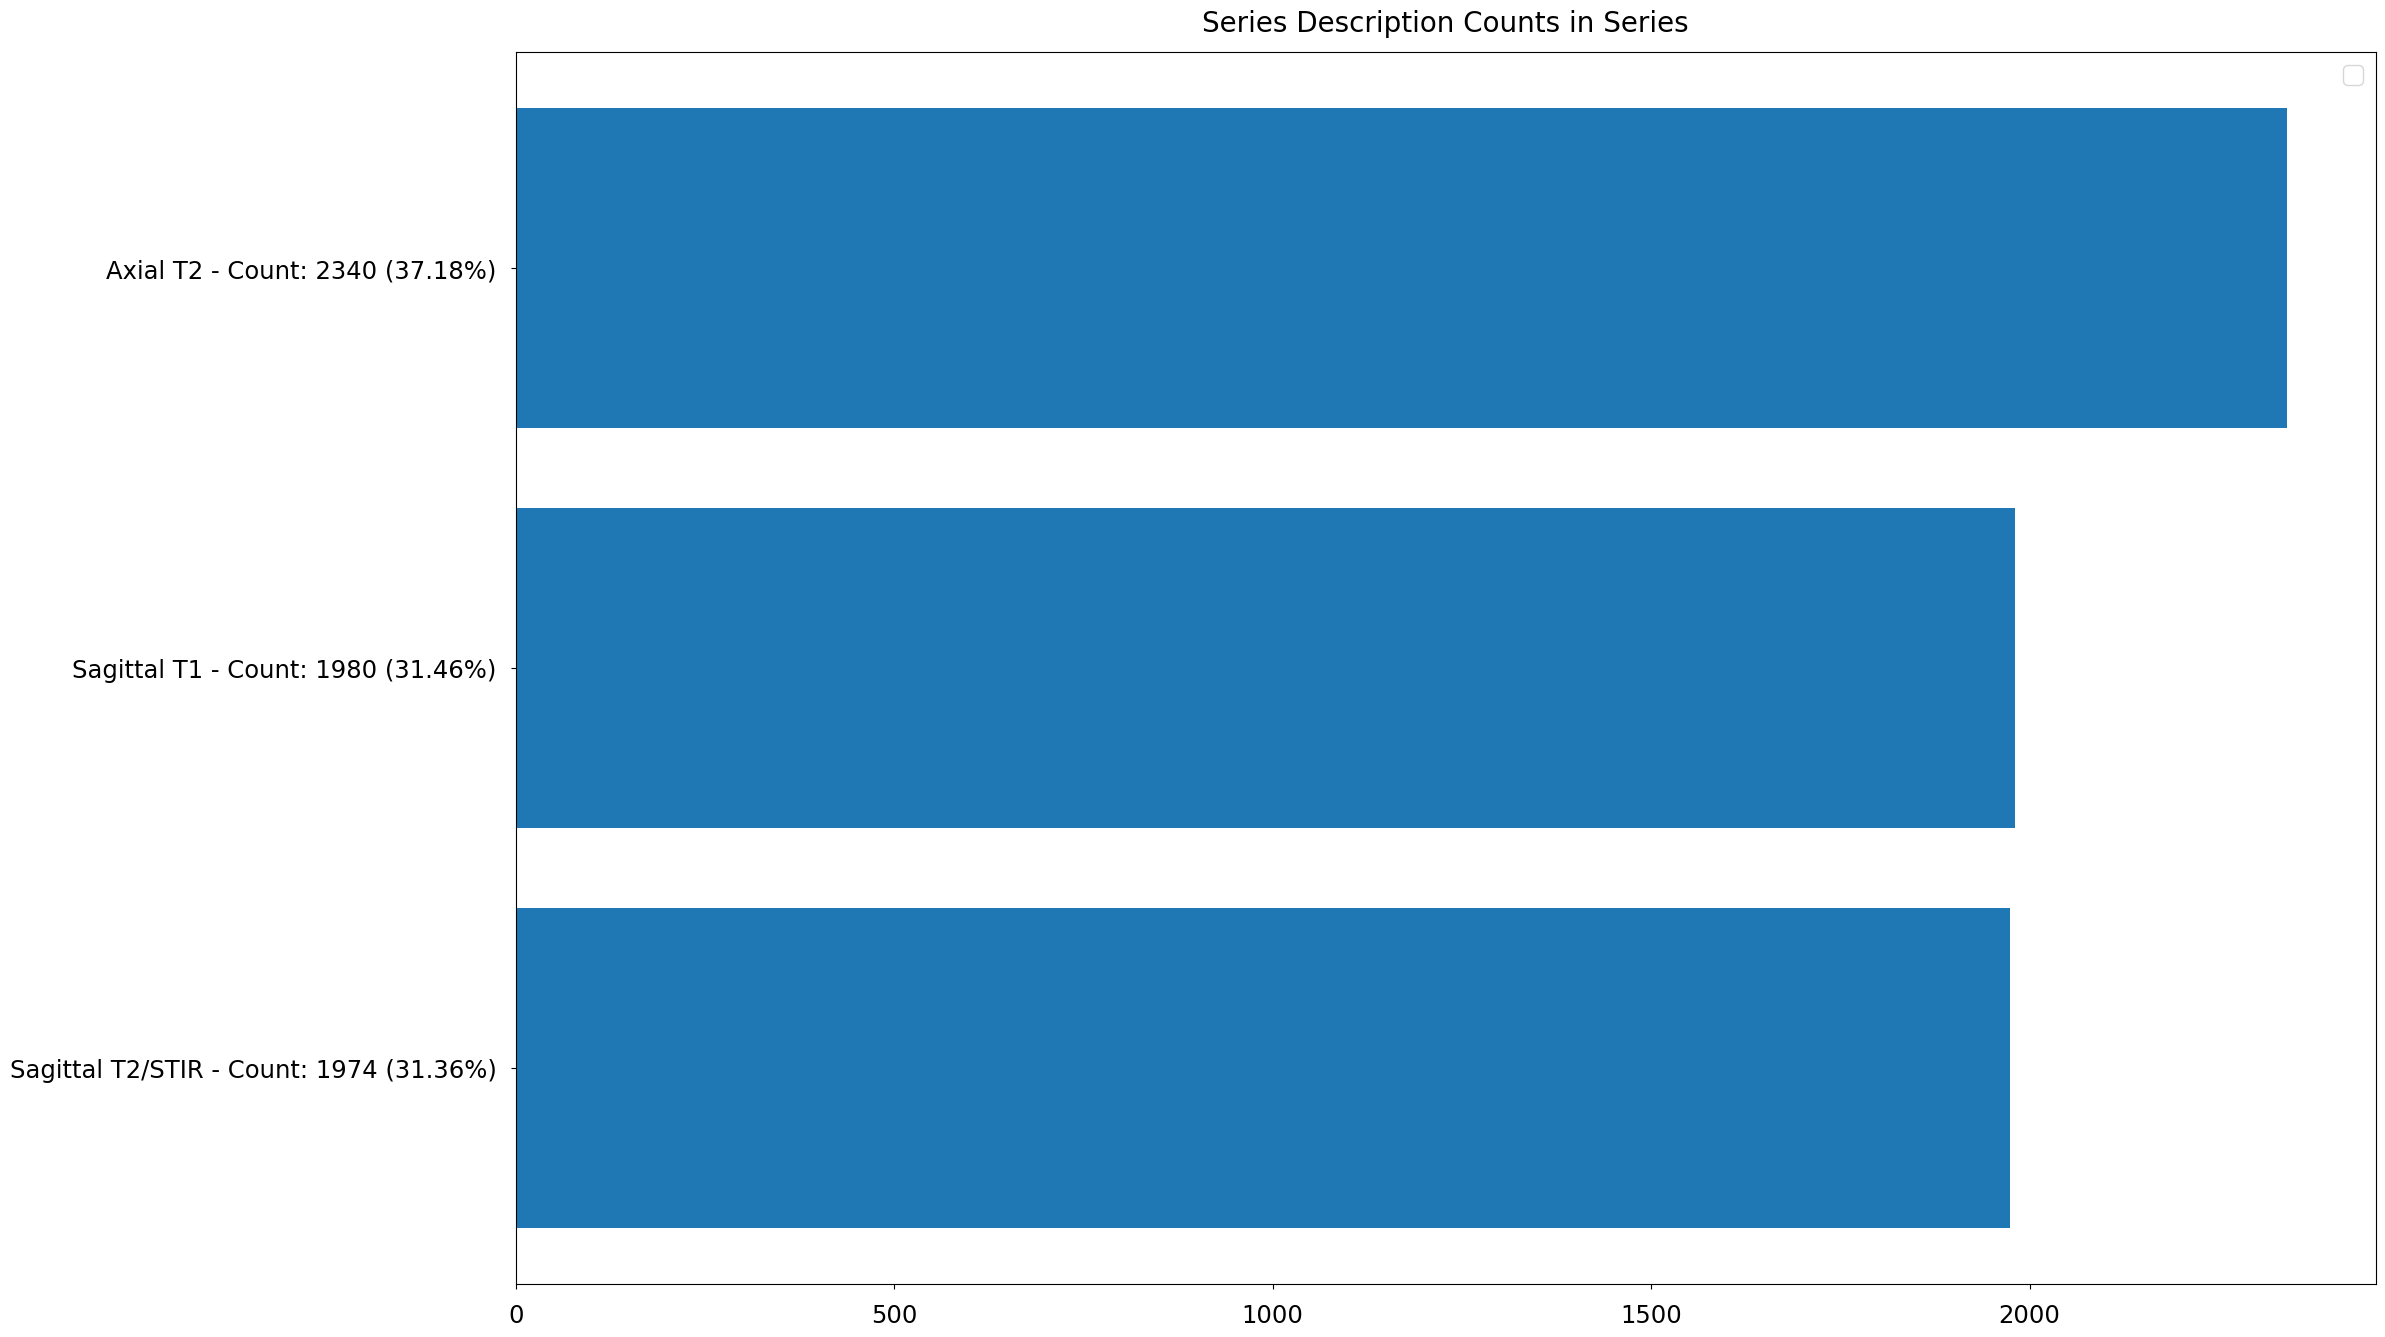

In [25]:
visualize_counts(df=df_train_series_description_counts, value='series_description', title='Series Description Counts in Series')

## 6. Label Coordinates

Label coordinates are provided in `train_label_coordinates.csv` file. They are the x/y coordinates for the center of the area where the condition is observed.

Study level labels and series descriptions can be merged to label coordinates dataframe on id fields.

In [26]:
print(f'Train Label Coordinates Shape: {df_train_label_coordinates.shape}')
print(f'Annotated Studies {df_train_label_coordinates["study_id"].nunique()}/{df_train.shape[0]}')
print(f'Annotated Series {df_train_label_coordinates["series_id"].nunique()}/{df_train_series_descriptions.shape[0]}')

df_train_label_coordinates = df_train_label_coordinates.merge(
    df_train,
    on='study_id',
    how='left'
).merge(
    df_train_series_descriptions,
    on=['study_id', 'series_id'],
    how='left'
)

display(df_train_label_coordinates)

Train Label Coordinates Shape: (48692, 7)
Annotated Studies 1974/1975
Annotated Series 6291/6294


,study_id,series_id,instance_number,condition,level,x,y,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,series_description,plane,modality
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR,Sagittal,T2/STIR
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR,Sagittal,T2/STIR
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR,Sagittal,T2/STIR
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR,Sagittal,T2/STIR
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T2/STIR,Sagittal,T2/STIR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T1,Sagittal,T1
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Sagittal T1,Sagittal,T1
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624,Normal/Mild,Norm

All of the studies in the dataset have label coordinates except **3008676218**, which is the only study with missing spinal canal stenosis label. 3 series without label coordinates belong to that study.

In [27]:
display(df_train.loc[~df_train['study_id'].isin(df_train_label_coordinates['study_id'])])
display(df_train_series_descriptions.loc[~df_train_series_descriptions['series_id'].isin(df_train_label_coordinates['series_id'])])

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
1378,3008676218,NaN,NaN,NaN,NaN,NaN,Normal/Mild,Severe,Moderate,Moderate,Severe,Normal/Mild,Moderate,Severe,Moderate,Moderate,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Severe,Normal/Mild,Normal/Mild


,study_id,series_id,series_description,plane,modality
4397,3008676218,542282425,Sagittal T1,Sagittal,T1
4398,3008676218,3636216534,Axial T2,Axial,T2
5332,3637444890,3892989905,Sagittal T2/STIR,Sagittal,T2/STIR


In [28]:
df_train_label_coordinates_counts = df_train_label_coordinates.groupby('study_id')['study_id'].count().value_counts().reset_index().rename(columns={'study_id': 'label_coordinate_count'})
df_train_label_coordinates_counts['percentage'] = df_train_label_coordinates_counts['count'] / df_train_label_coordinates_counts['count'].sum(axis=0) * 100

Number of label coordinate counts in studies can be between 15 and 25, but more than 90% of the studies have 25 label coordinates which is the exact same number as levels (5) multiplied with conditions (5). It shows that most of the studies have label coordinates for all conditions and levels even though the condition is Normal/Mild. In addition to that, number of label coordinate counts being less than 25 could be related to missing conditions.

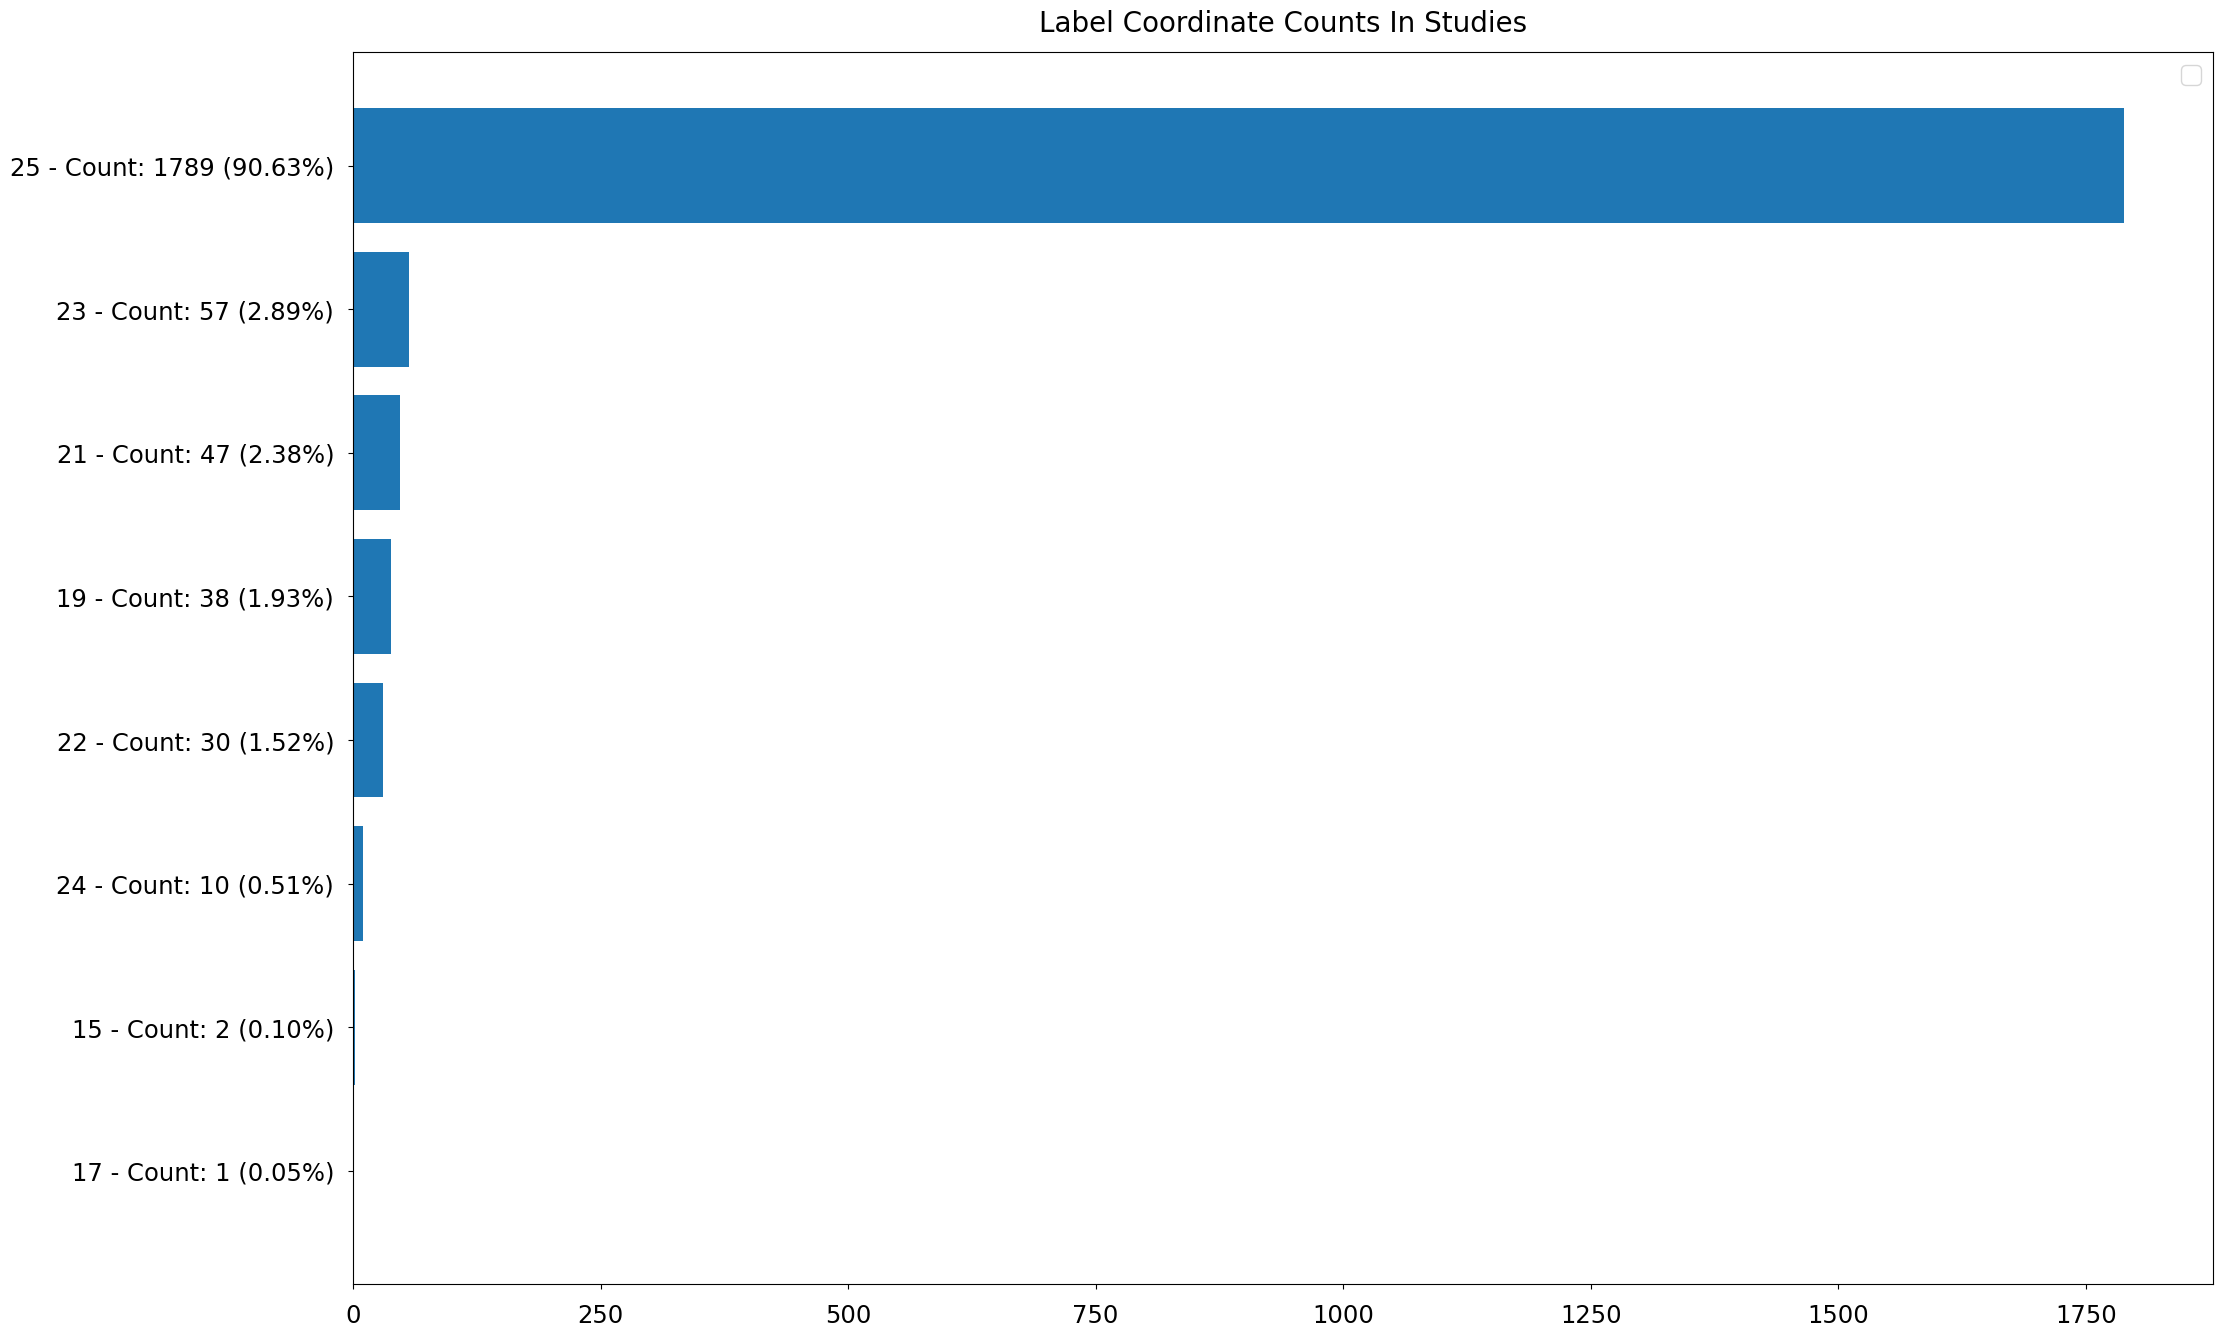

In [29]:
visualize_counts(df=df_train_label_coordinates_counts, value='label_coordinate_count', title='Label Coordinate Counts In Studies')

In [30]:
df_train_label_coordinates_counts = df_train_label_coordinates.groupby(['study_id', 'series_id'])['series_id'].count().value_counts().reset_index().rename(columns={'series_id': 'label_coordinate_count'})
df_train_label_coordinates_counts['percentage'] = df_train_label_coordinates_counts['count'] / df_train_label_coordinates_counts['count'].sum(axis=0) * 100

Number of label coordinate counts in series is between 1 and 10 most of the time, but there is one study that has 15 label coordinates in one series. It shows that label coordinates of each condition are given only for specific modalities. It is very likely that some modalities are taken for certain conditions.

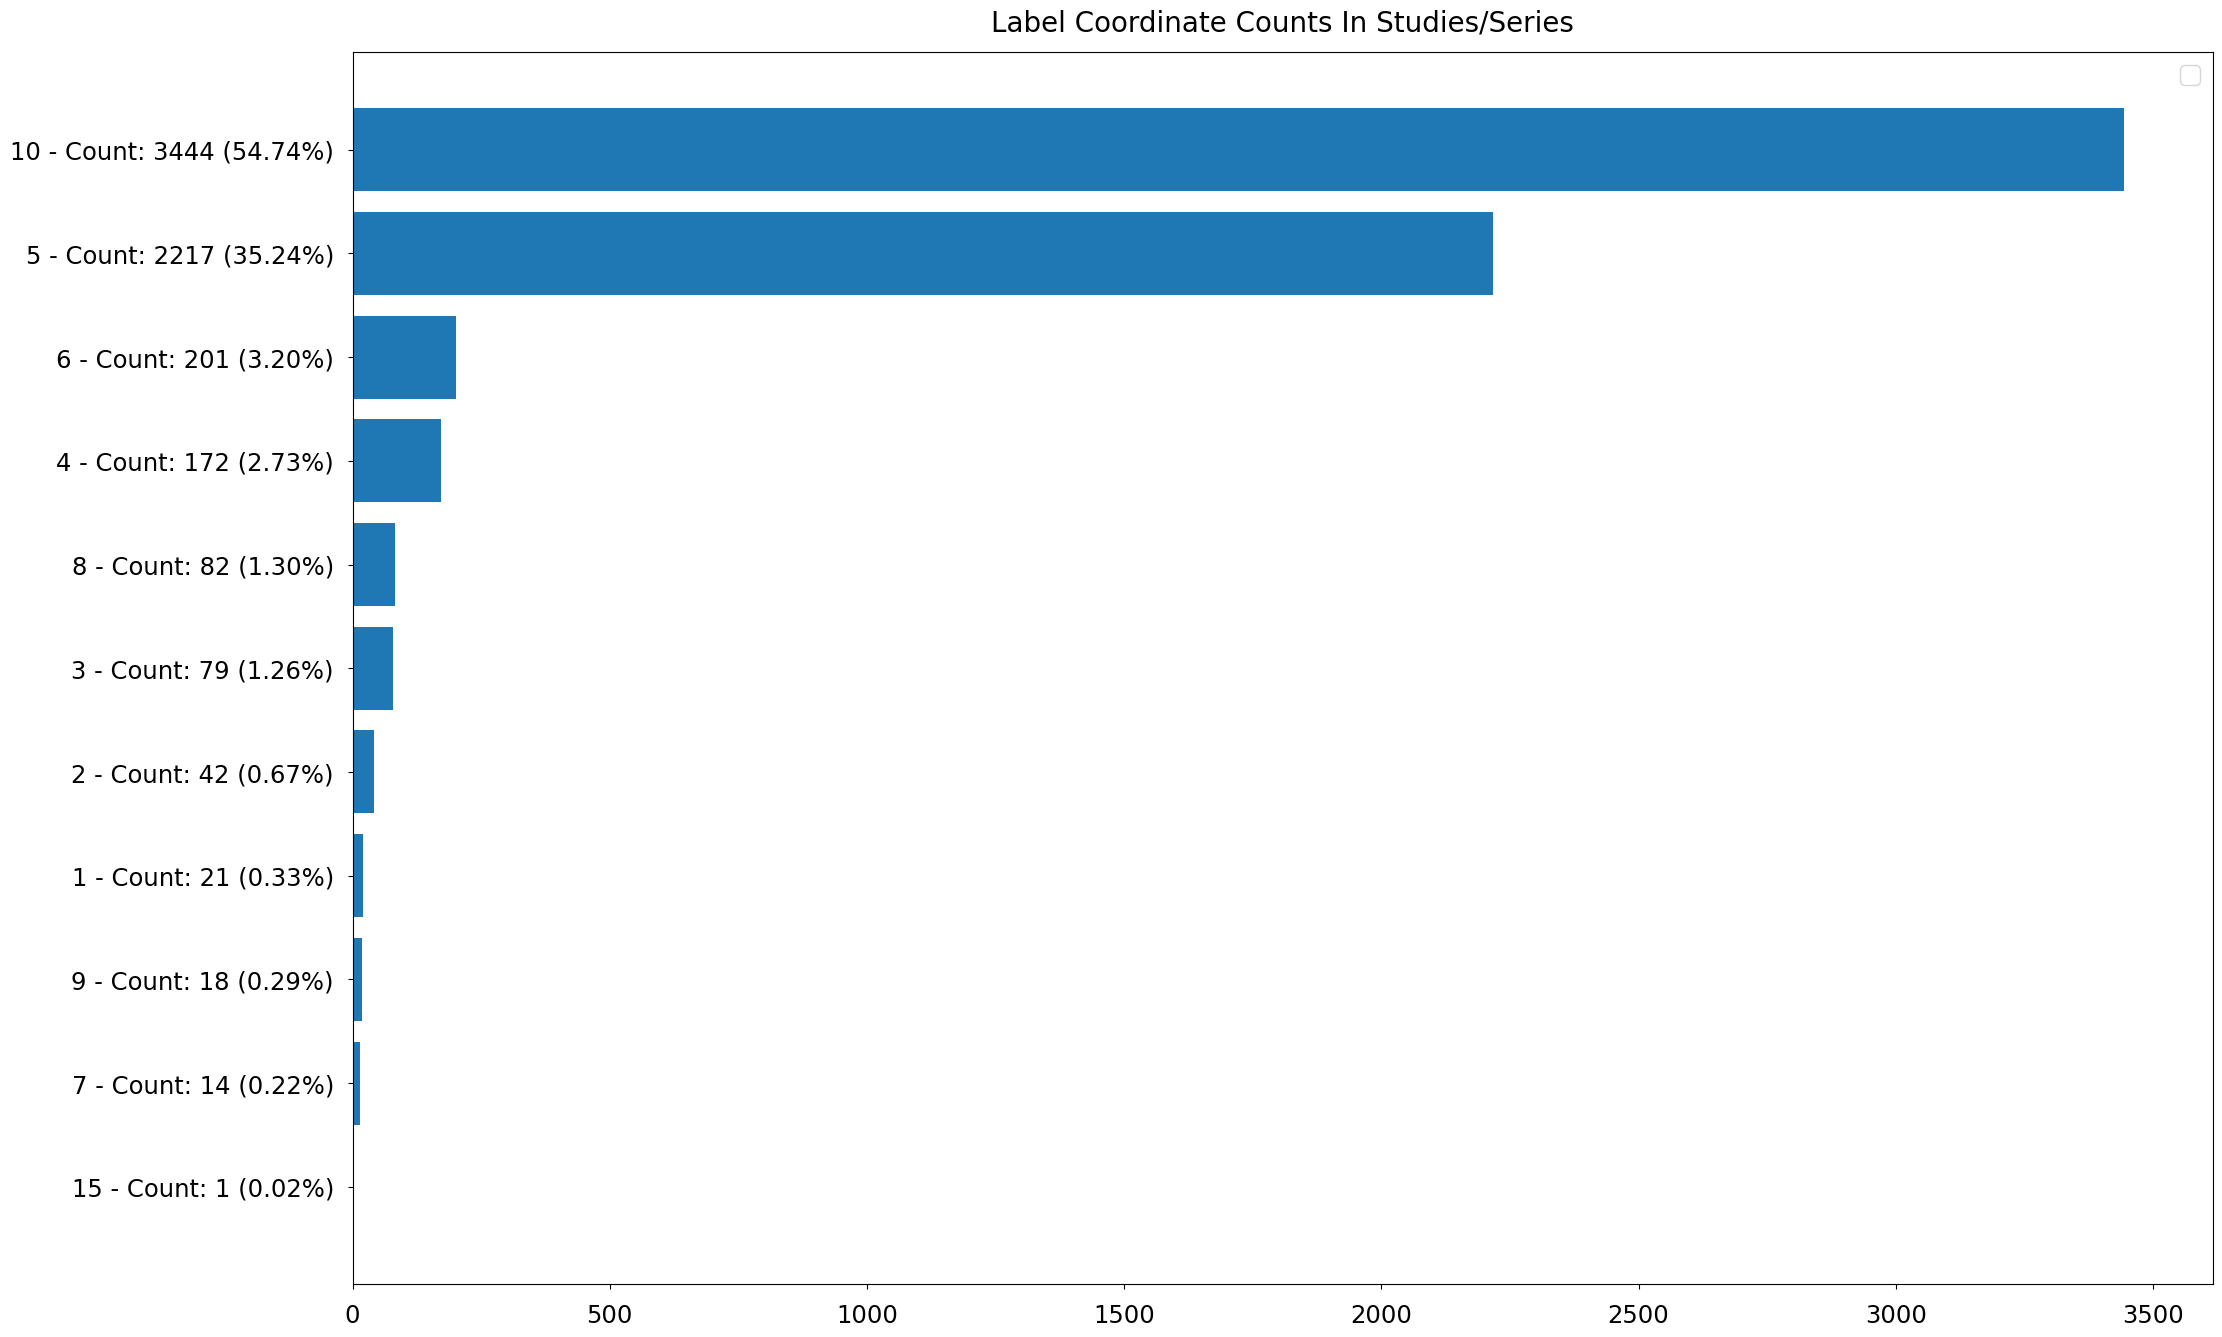

In [31]:
visualize_counts(df=df_train_label_coordinates_counts, value='label_coordinate_count', title='Label Coordinate Counts In Studies/Series')

Aggregation of label coordinate counts within condition groups show that some modalities are only taken for certain conditions.

* Spinal canal stenosis conditions are almost always Sagittal T2/STIR, but there are 5 label coordinates (1 series) that are from Sagittal T1
* Neural foraminal narrowing conditions are always Sagittal T1
* Subarticular stenosis conditions are always Axial T2

Those modalities and planes could be more effective for detecting the corresponding conditions however other series can be used for predicting the same condition as well.

In [32]:
display(df_train_label_coordinates.groupby('condition')['series_description'].value_counts().reset_index())

,condition,series_description,count
0,Left Neural Foraminal Narrowing,Sagittal T1,9860
1,Left Subarticular Stenosis,Axial T2,9608
2,Right Neural Foraminal Narrowing,Sagittal T1,9859
3,Right Subarticular Stenosis,Axial T2,9612
4,Spinal Canal Stenosis,Sagittal T2/STIR,9748
5,Spinal Canal Stenosis,Sagittal T1,5


Locations of coordinate labels can be visualized as a heatmap with the function below.

In [33]:
def visualize_heatmap(heatmap, title, path=None):

    """
    Visualize given heatmap

    Parameters
    ----------
    heatmap: numpy.ndarray of shape (height, width)
        Heatmap array

    title: str
        Title of the plot

    path: str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(heatmap, cmap=plt.cm.hot)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(title, size=15, pad=12.5, loc='center', wrap=True)

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


In [34]:
df_train_label_coordinates_sagittal_t1 = df_train_label_coordinates.loc[df_train_label_coordinates['series_description'] == 'Sagittal T1']
sagittal_t1_heatmap = np.zeros((
    int(df_train_label_coordinates_sagittal_t1['y'].max()) + 1,
    int(df_train_label_coordinates_sagittal_t1['x'].max()) + 1,
))
for idx, row in tqdm(df_train_label_coordinates_sagittal_t1.iterrows(), total=df_train_label_coordinates_sagittal_t1.shape[0]):
    sagittal_t1_heatmap[
        int(row['y']) - 10:int(row['y']) + 10,
        int(row['x']) - 10:int(row['x']) + 10,
        
    ] += 1

df_train_label_coordinates_sagittal_t2 = df_train_label_coordinates.loc[df_train_label_coordinates['series_description'] == 'Sagittal T2/STIR']
sagittal_t2_heatmap = np.zeros((
    int(df_train_label_coordinates_sagittal_t2['y'].max()) + 1,
    int(df_train_label_coordinates_sagittal_t2['x'].max()) + 1
))
for idx, row in tqdm(df_train_label_coordinates_sagittal_t2.iterrows(), total=df_train_label_coordinates_sagittal_t2.shape[0]):
    sagittal_t2_heatmap[
        int(row['y']) - 10:int(row['y']) + 10,
        int(row['x']) - 10:int(row['x']) + 10
    ] += 1

df_train_label_coordinates_axial_t2 = df_train_label_coordinates.loc[df_train_label_coordinates['series_description'] == 'Axial T2']
axial_t2_heatmap = np.zeros((
    int(df_train_label_coordinates_axial_t2['y'].max()) + 1,
    int(df_train_label_coordinates_axial_t2['x'].max()) + 1
))
for idx, row in tqdm(df_train_label_coordinates_axial_t2.iterrows(), total=df_train_label_coordinates_axial_t2.shape[0]):
    axial_t2_heatmap[
        int(row['y']) - 10:int(row['y']) + 10,
        int(row['x']) - 10:int(row['x']) + 10
    ] += 1

100%|██████████| 19220/19220 [00:02<00:00, 9517.82it/s]


Heatmaps show that label coordinates are curving from top left to bottom right which makes sense for sagittal plane but not so much for axial plane. Label coordinates curving on axial plane may be related to them being raw, not normalized. There would be higher overlap if coordinates were normalized with height and width of the slices.

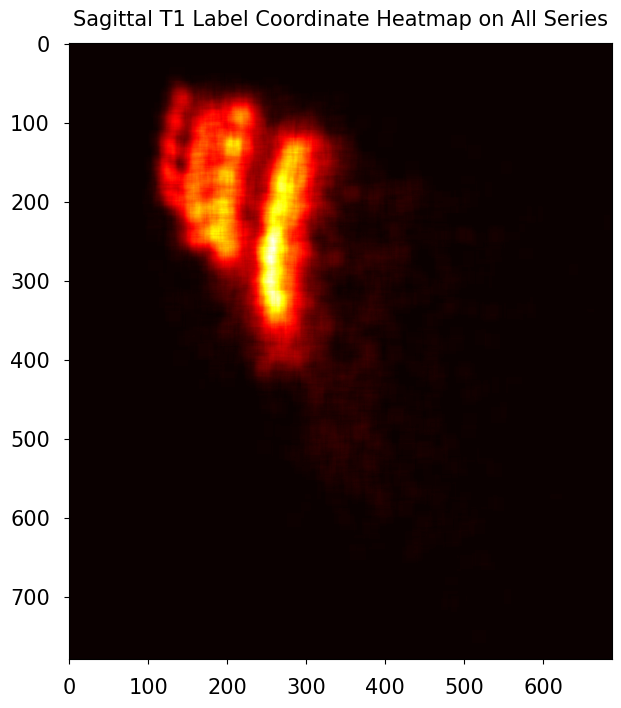

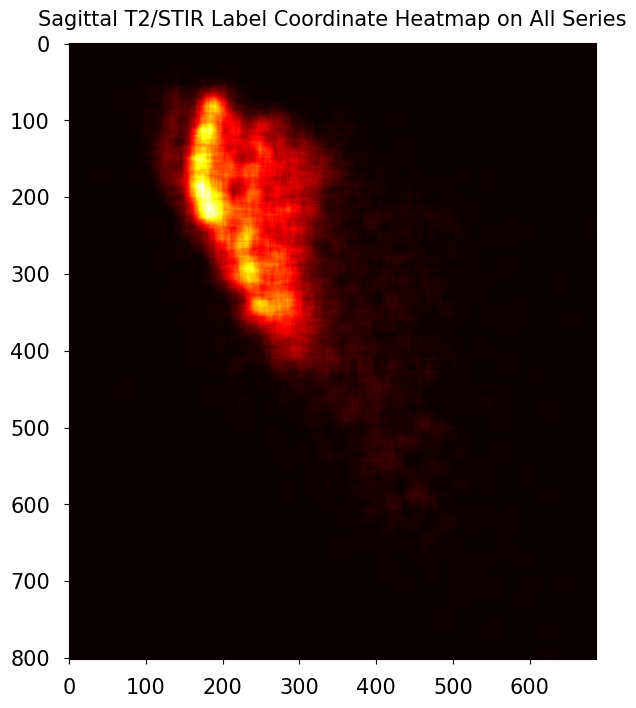

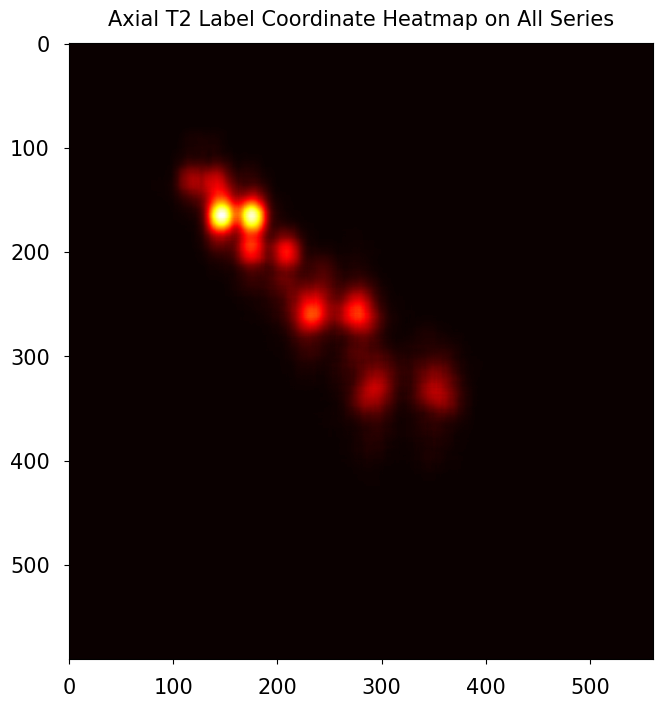

In [35]:
visualize_heatmap(sagittal_t1_heatmap, title='Sagittal T1 Label Coordinate Heatmap on All Series')
visualize_heatmap(sagittal_t2_heatmap, title='Sagittal T2/STIR Label Coordinate Heatmap on All Series')
visualize_heatmap(axial_t2_heatmap, title='Axial T2 Label Coordinate Heatmap on All Series')

## 7. DICOM Metadata